# Multi-Class Anomaly Detection

Author: Rithwik Gupta (rithwikca2020@gmail.com)

Supervised by Daniel Muthukrishna (danmuth@mit.edu)

This notebook generates the results in the paper "A Classifier-Based Approach to Multi-Class Anomaly Detection for
Astronomical Transients" https://arxiv.org/abs/2403.14742

In this notebook, we will preprocess and explores the dataset, and then train a recurrent neural network classifier on known classes. We will then uses the classifier as an encoder to generate a latent space for anomaly detection. We will train a Isolation Forests for each known class and apply "Multi-Class Isoaltion Forests" to identify anomalies in the dataset.


## Load the Data

We will use simulated light curves matching the properties of the Zwicky Transient Facility. These simulations were developed using similar code used to generate the [PLAsTiCC](https://plasticc.org/) simulations. We ahve done some preprocessing on these light curves, and have will load the light curves that have been previously stored into pickle files.

Download the data from here: https://drive.google.com/file/d/1rfc-fWhYgNgz7szmIi9Kv5xdcWvtCmdh/view?usp=drive_link (We have also provided the data on the Bridges-2 cluster)


We use the following 5 classes as anomlaous classes: 'AGN', 'CaRT', 'KNe', 'PISN', 'ILOT', 'uLens-BSR'

And the following 12 classes as the common classes: 'SNIa', 'SNIa-91bg', 'SNIax', 'SNIb', 'SNIc', 'SNIc-BL', 'SNII', 'SNIIn', 'SNIIb', 'TDE', 'SLSN-I',

In [121]:
file_names = ['lc_classnum_Ia.pickle',
'lc_classnum_Ia-91bg.pickle', 
'lc_classnum_Iax.pickle', 
'lc_classnum_Ib.pickle', 
'lc_classnum_Ic.pickle',  
'lc_classnum_Ic-BL.pickle',  
'lc_classnum_II.pickle', 
'lc_classnum_IIn.pickle', 
'lc_classnum_IIb.pickle', 
'lc_classnum_TDE.pickle', 
'lc_classnum_SLSN-I.pickle', 
'lc_classnum_AGN.pickle',
'lc_classnum_CART.pickle',
'lc_classnum_Kilonova.pickle',
'lc_classnum_PISN.pickle',
'lc_classnum_ILOT.pickle',
'lc_classnum_uLens-BSR.pickle']

# Class names in the same order as the filenames
classes = ['SNIa', 'SNIa-91bg', 'SNIax', 'SNIb', 'SNIc', 'SNIc-BL', 'SNII', 'SNIIn', 'SNIIb', 'TDE', 'SLSN-I', 'AGN', 'CaRT', 'KNe', 'PISN', 'ILOT', 'uLens-BSR']

# Map class names to file names
file_to_class = dict(zip(file_names, classes)) # Dictionary from filename to the classname
class_to_file = {v: k for k, v in file_to_class.items()} # # Dictionary from classname to the filename

# Define Anomalous Classes as the last 5 classes, and common classes as the first 12 classes
anom_classes = file_names[-5:]
non_anom_classes = file_names[:-5]

# Colors for plotting  
colors = ['r', 'g', 'y', 'b', 'purple', 'orange', 'gray', 'k', 'm', 'c', 'brown', 'olive']


In [122]:
# ZTF band median wavelengths (in micrometers)
band_medians = {'r' : 0.4827, 'g' : 0.6223}

In [123]:
# Load pickle files
full_data = []
for filename in file_names:
  data = pickle.load(open(f"ZTF_sims/{filename}", "rb"))
  full_data.append(data)


### Explore the data
Our ZTF simulations have already been processed such that all times are relative to the time of the first detection (trigger). Let's examine an example light curve in the dataset.

The data has 5 columns: passband, time relative to trigger, flux, flux error, and photflag. 

photflag takes 3 values. 6144 for the first detection, 4096 for a detection, and 0 for a non-detection.

In [124]:
# This is the dataframe for an example PISN light curve with object ID 61_25609270.
i = classes.index('PISN')
full_data[i]['61_25609270']

passband,time,flux,fluxErr,photflag
str1,float32,float32,float32,int32
g,0.0,542.922,50.13175,6144
g,3.02,461.256,81.78348,4096
g,17.9746,520.43085,50.334007,4096
g,27.955,561.1466,49.44025,4096
g,31.876,541.00323,100.70866,0
g,34.8942,571.265,172.87912,0
g,38.9377,559.15735,121.22724,0
g,41.8737,438.6405,62.686382,4096
g,48.8702,545.1847,52.144913,4096


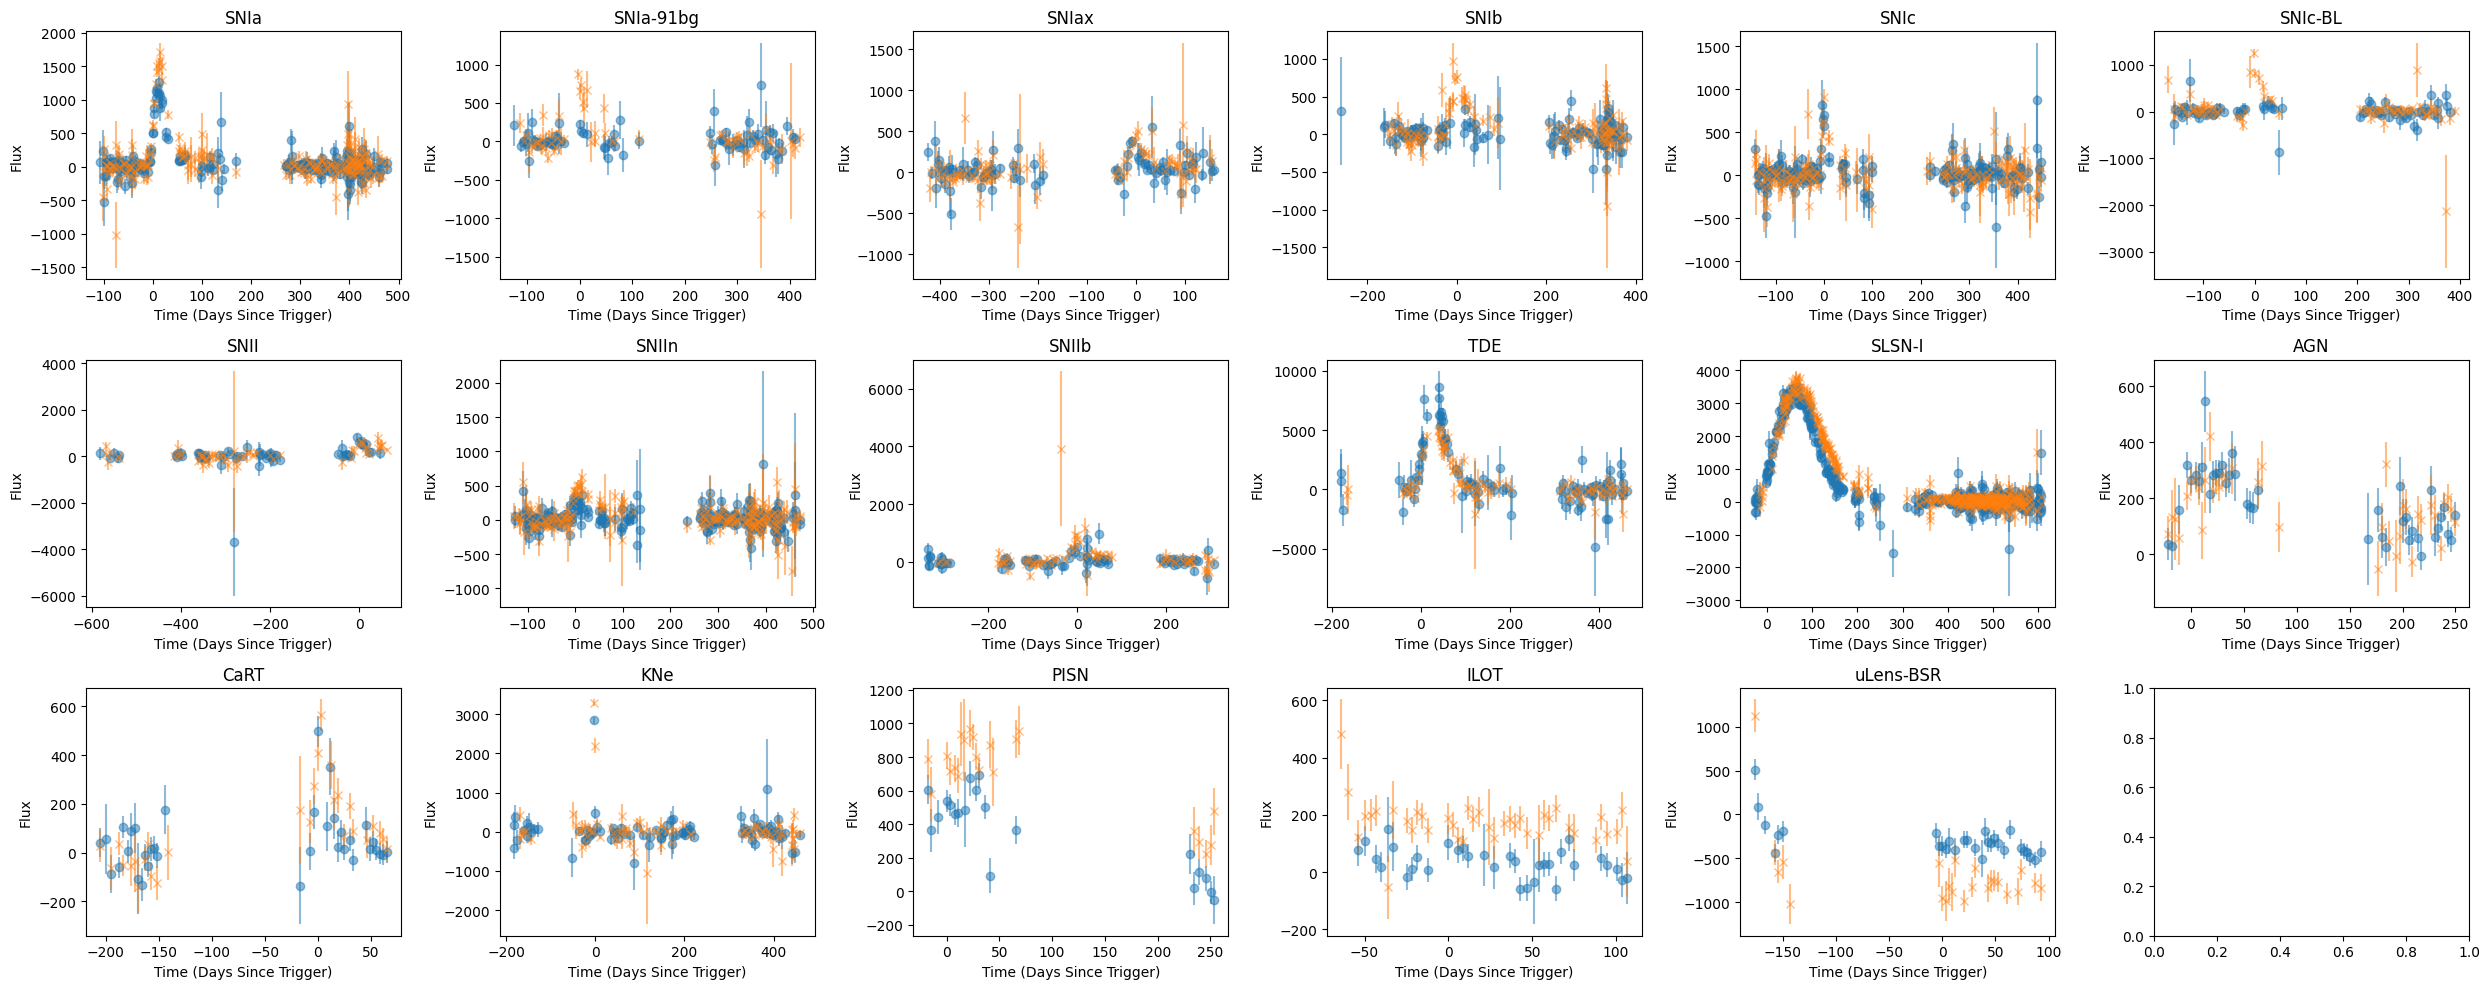

In [125]:
# Let's plot some example light curve
matplotlib.rcParams.update({'font.size': 10})

fig, axs = plt.subplots(3, 6, figsize=(25, 10))
axes = axs.flatten()

for i, c_name in enumerate(classes):

    class_data = full_data[i]

    axes[i].set_title(c_name)
    # Plot one light curve from each class
    for lc_name in class_data.keys():
        lc_data = class_data[lc_name]
        lc_data = pd.DataFrame(np.array(lc_data))
        
        # Check that the time zero corresponds to the first detection (phot flag 6144)
        assert(lc_data[lc_data['photflag'] == 6144]['time'].all() == 0)

        # Plot the light curve
        pb_mask = lc_data['passband'] == 'g'
        axes[i].errorbar(lc_data['time'][pb_mask], lc_data['flux'][pb_mask], yerr=lc_data['fluxErr'][pb_mask], fmt='o', color='tab:blue', alpha=0.5)
        pb_mask = lc_data['passband'] == 'r'
        axes[i].errorbar(lc_data['time'][pb_mask], lc_data['flux'][pb_mask], yerr=lc_data['fluxErr'][pb_mask], fmt='x', color='tab:orange', alpha=0.5)

        break

    axes[i].set_xlabel('Time (Days Since Trigger)')
    axes[i].set_ylabel('Flux')
plt.tight_layout()
plt.show()


In [116]:
# Plot example transients from a given class

def plot_raw(class_name, num_samples=5):
    
    class_ind = file_names.index(class_to_file[class_name])

    keys = list(full_data[class_ind].keys())
    key = None
    counter = 0
    for i in range(len(keys)):
        key = keys[i]
        if full_data[class_ind][key].meta['redshift'] < 0.2 and full_data[class_ind][key][np.argmax(full_data[class_ind][key]['flux'])]['time'] < 0:
        
            # print(full_data[class_ind][key].meta['class_num'])
            full_data[class_ind][key] = full_data[class_ind][key][(full_data[class_ind][key]['time'] < 70) & (full_data[class_ind][key]['time'] > -30)]
         
            plt.errorbar(full_data[class_ind][key][full_data[class_ind][key]['passband'] == 'g']['time'], full_data[class_ind][key][full_data[class_ind][key]['passband'] == 'g']['flux'], yerr = full_data[class_ind][key][full_data[class_ind][key]['passband'] == 'g']['fluxErr'], fmt='.',label='g')
            plt.errorbar(full_data[class_ind][key][full_data[class_ind][key]['passband'] == 'r']['time'], full_data[class_ind][key][full_data[class_ind][key]['passband'] == 'r']['flux'], yerr = full_data[class_ind][key][full_data[class_ind][key]['passband'] == 'r']['fluxErr'], fmt='.',label='r')
            plt.legend()
            plt.xlabel("Time Since Trigger")
            plt.ylabel("Measured Flux")
            plt.title(f"Sample {class_name}")
            plt.show()

            counter += 1
            if counter > num_samples:
                break

In [118]:
# plot_raw('SNIa', num_samples=3)

## Preprocess the Data

The main preprocessing loop follows. I think its better to run this on your own data, but definitely use this as a template for preprocessing.

If the next part is done correctly everything else is smooth sailing. The final output of preprocessing should be 3 arrays.

1. *x_data*: information for each light curve. Length of each entry should be the number of observations in that light curve. Each timestep should have the scaled time, scaled flux, scaled flux error, median passband wavelength

2. *host_galaxy_info*: Each entry should be an array of 2 values. This is not fixed though and you'll like include less (or more) host galaxy information

3. *target*: target class for each curve (filename is what I used, but it can be the class name as well)

I recommend that if you are planning to run this on your own data, adjust the preprocesing step so that the array *target* stores the class name, not the file name. This makes it a lot less confusing.

Other stuff you need (dataset specific) follows


1. file_names: slightly misleading name but its basically np.unique(target)

2. file_to_class: dictionary from what is stored in target for each class to what you want to show on plots

2. anom_classes: list of values in target that are those of anomalous classes

3. non_anom_classes: list of values in target that are those of common classes

You can see an examples in the 2nd code block

Here we estimate the mean so that we have a reasonable constant to divide all fluxes by. We can't scale per light curve as thats not possible in real-time

In [ ]:
x_data = [] # info => for each time step, store time, median passband wavelength, flux, flux error
host_galaxy_info = [] # just 2 numbers per time step
target = [] # store target class (filename)


In [ ]:
import os

band_medians = {'r' : 0.4827, 'g' : 0.6223} # Median Wavelength (in Angstroms) Scaled over 10000 for ZTF


before = 30
after = 70

for ind, filename in enumerate(file_names):

  data = full_data[ind]

  ids = list(data.keys())

   
  for id in ids:
 
    df = data[id]
    df = pd.DataFrame(np.array(df)) # astropy table to pandas dataframe
    
    cur_meta = [data[id].meta['redshift'], data[id].meta['mwebv']] # host gal info, redshift and extinction

    # Scale flux
    df['flux'] = (df['flux']) / 500
    df['fluxErr'] = (df['fluxErr']) / 500

    trigger_mjd = 0 # CHANGE THIS IF TRIGGER IS NOT AT 0

    df = df[(df['time'] > trigger_mjd - before) & (df['time'] < trigger_mjd + after)] # Cut on time

    
    if (len(df) == 0): # Remove (empty) sufficiently small light curves
        continue

    df.sort_values("time", inplace=True) # Sort by time
    df.drop('photflag', axis=1, inplace=True)

    df.time = (df.time - (-before)) / (after + before) # Scale Time


    df['passband'] = df['passband'].map(band_medians)

    x_data.append(np.array(df))
    target.append(filename)
    host_galaxy_info.append(cur_meta)

  print(ind) # Progress update


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16


In [ ]:
def save(file_name , obj):
    with open(file_name, 'wb') as f:
        pickle.dump(obj, f)

In [ ]:
# Save data
        
save("new_pre/target", target)
save("new_pre/x_data", x_data)
save("new_pre/host_galaxy_info", host_galaxy_info)

In [ ]:
def load(file_name):
    with open(file_name, 'rb') as f:
        return pickle.load(f)

target = load("new_pre/target")
x_data = load("new_pre/x_data")
host_galaxy_info = load("new_pre/host_galaxy_info")


If you're here, you should have preprocessed data!

In [ ]:
# Cuts classes to 13,000 transients max

valid = [False] * len(target)

for class_ in np.unique(target):
    cnt = 0
    for i in range(len(target)):
        
        if (target[i] == class_):
            valid[i] = True
            cnt+=1
        if (cnt == 13000): # cut down
            break
for i in range(len(target) - 1, -1, -1):
    if not valid[i]:
        del target[i]
        del x_data[i]
        del host_galaxy_info[i]

In [ ]:
lengths = []

for lc in x_data:
    lengths.append(len(lc))

ntimesteps = np.max(lengths)

print(ntimesteps)

656


In [ ]:
# Pad for TF masking layer
def dilate(vals, red):
    return ((((vals * 100) - 30) / (1 + red)) + 30) / 100 # unscale time then correct 


for ind in range(len(x_data)):
  x_data[ind][:, 1] = dilate(x_data[ind][:, 1], host_galaxy_info[ind][0])
  x_data[ind] = np.pad(x_data[ind], ((0, ntimesteps - len(x_data[ind])), (0, 0)))

In [ ]:
x_data = np.array(x_data)

In [ ]:
# Split data

y_data_anom = []
y_data_norm = []
x_data_norm = []
x_data_anom = []
host_gal_anom = []
host_gal = []

for i in range(len(target)):

    if (target[i] in anom_classes):
        x_data_anom.append(x_data[i])
        y_data_anom.append(target[i])
        host_gal_anom.append(host_galaxy_info[i])

    else:
        x_data_norm.append(x_data[i])
        y_data_norm.append(target[i])
        host_gal.append(host_galaxy_info[i])



In [ ]:
np.unique(target)

array(['lc_classnum_AGN_old.pickle', 'lc_classnum_CART_old.pickle',
       'lc_classnum_II.pickle', 'lc_classnum_IIb.pickle',
       'lc_classnum_IIn.pickle', 'lc_classnum_ILOT_old.pickle',
       'lc_classnum_Ia-91bg.pickle', 'lc_classnum_Ia.pickle',
       'lc_classnum_Iax.pickle', 'lc_classnum_Ib.pickle',
       'lc_classnum_Ic-BL.pickle', 'lc_classnum_Ic.pickle',
       'lc_classnum_Kilonova.pickle', 'lc_classnum_PISN_old.pickle',
       'lc_classnum_SLSN-I.pickle', 'lc_classnum_TDE.pickle',
       'lc_classnum_uLens-BSR.pickle'], dtype='<U28')

In [ ]:
# One-hot Encoding

from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore')

y_data_norm = enc.fit_transform(np.array(y_data_norm).reshape(-1, 1)).todense()

In [ ]:
# Train-test split

X_train, X_test, host_gal_train, host_gal_test, y_train, y_test = train_test_split(x_data_norm, host_gal, y_data_norm, random_state = 40, test_size = 0.1)


In [ ]:
X_train, X_val, host_gal_train, host_gal_val, y_train, y_val = train_test_split(X_train, host_gal_train, y_train, random_state = 40, test_size = 1/9)

In [ ]:
class_weights = {i : 0 for i in range(y_train.shape[1])}

for value in y_train:
  class_weights[np.argmax(value)]+=1

for id in class_weights.keys():
  class_weights[id] = len(y_train) / class_weights[id]


In [ ]:
ntimesteps

656

In [ ]:
X_train = np.array(X_train)
y_train = np.array(y_train)

X_val = np.array(X_val)
y_val = np.array(y_val)

X_test = np.array(X_test)
y_test = np.array(y_test)

host_gal_train = np.array(host_gal_train)
host_gal_test = np.array(host_gal_test)
host_gal_val = np.array(host_gal_val)

y_train = np.squeeze(y_train)
y_val = np.squeeze(y_val)
y_test = np.squeeze(y_test)
y_data_anom = np.squeeze(y_data_anom)

In [ ]:
X_train.shape

(95182, 656, 4)

In [ ]:
dummy = enc.transform(np.array(non_anom_classes).reshape(-1, 1))

ordered_class_names = [-1 for i in range(len(non_anom_classes))]


for ind, i in enumerate(dummy.todense()):
    ordered_class_names[np.argmax(i)] = file_to_class[non_anom_classes[ind]] # If you don't use filenames then you don't need file_to_class here

In [ ]:
np.unique(target)

array(['lc_classnum_AGN_old.pickle', 'lc_classnum_CART_old.pickle',
       'lc_classnum_II.pickle', 'lc_classnum_IIb.pickle',
       'lc_classnum_IIn.pickle', 'lc_classnum_ILOT_old.pickle',
       'lc_classnum_Ia-91bg.pickle', 'lc_classnum_Ia.pickle',
       'lc_classnum_Iax.pickle', 'lc_classnum_Ib.pickle',
       'lc_classnum_Ic-BL.pickle', 'lc_classnum_Ic.pickle',
       'lc_classnum_Kilonova.pickle', 'lc_classnum_PISN_old.pickle',
       'lc_classnum_SLSN-I.pickle', 'lc_classnum_TDE.pickle',
       'lc_classnum_uLens-BSR.pickle'], dtype='<U28')

In [ ]:
non_anom_classes

['lc_classnum_Ia.pickle',
 'lc_classnum_Ia-91bg.pickle',
 'lc_classnum_Iax.pickle',
 'lc_classnum_Ib.pickle',
 'lc_classnum_Ic.pickle',
 'lc_classnum_Ic-BL.pickle',
 'lc_classnum_II.pickle',
 'lc_classnum_IIn.pickle',
 'lc_classnum_IIb.pickle',
 'lc_classnum_TDE.pickle',
 'lc_classnum_SLSN-I.pickle',
 'lc_classnum_AGN_old.pickle']

In [ ]:
np.unique(y_data_anom)

array(['lc_classnum_CART_old.pickle', 'lc_classnum_ILOT_old.pickle',
       'lc_classnum_Kilonova.pickle', 'lc_classnum_PISN_old.pickle',
       'lc_classnum_uLens-BSR.pickle'], dtype='<U28')

In [ ]:
# Generate Table for Training Counts

train_counts = {i : 0 for i in file_to_class.values()}

for i in y_train:
    train_counts[ordered_class_names[np.argmax(i)]] += 1
    
val_counts = {i : 0 for i in file_to_class.values()}

for i in y_val:
    val_counts[ordered_class_names[np.argmax(i)]] += 1
    
test_counts = {i : 0 for i in file_to_class.values()}

for i in y_test:
    test_counts[ordered_class_names[np.argmax(i)]] += 1

In [ ]:


for i in y_data_anom:
    test_counts[file_to_class[i]] += 1

In [ ]:
full_data = {i: [] for i in reversed(file_to_class.values())}

for i in train_counts.keys():
    full_data[i].append(train_counts[i])
    
for i in val_counts.keys():
    full_data[i].append(val_counts[i])
    
for i in test_counts.keys():
    full_data[i].append(test_counts[i])

In [ ]:
for key, value in reversed(full_data.items()):
    print(f"{key} & {value[0]} & {value[1]} & {value[2]} & {value[1] + value[0] + value[2]} \\\\")
    print("\hline")


### Function to create model. Here you'll need to set the architecture. You'll probably just need to change the input shape for the input layers (commented with CHANGE) depending on whether you use host galaxy information or not.

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, TimeDistributed, Dense, Masking, concatenate, GRU
from tensorflow.keras.callbacks import EarlyStopping
from math import dist

def create_redshift(latent_size):

    num_classes = len(class_weights)
    n_features = 4

    input_1 = Input((ntimesteps, n_features), name='lc')  # X.shape = (Nobjects, Ntimesteps, 4) CHANGE

    masking_input1 = Masking(mask_value=0.)(input_1)

    lstm1 = GRU(100, return_sequences=True, activation='tanh')(masking_input1)
    lstm2 = GRU(100, return_sequences=False, activation='tanh')(lstm1)

    dense1 = Dense(100, activation='tanh')(lstm2)

    input_2 = Input(shape = (2, ), name='host') # CHANGE

    dense2 = Dense(10)(input_2)

    merge1 = concatenate([dense1, dense2])

    dense3 = Dense(100, activation='relu')(merge1)

    dense4 = Dense(latent_size, activation='relu', name='latent')(dense3)

    output = Dense(num_classes, activation='softmax')(dense4)

    model = keras.Model(inputs=[input_1, input_2], outputs=output)

    model.compile(loss = "categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
    
    return model

In [ ]:
# Object to store a trained model. Has MCIF built in.

from tensorflow.keras import Model
from sklearn.ensemble import IsolationForest
class Trained_Model:
    def __init__(self, size, redshift):
        
        self.size = size
        self.redshift = redshift
            
        
        
        
    def load_model(self, path):
        ins = 'No' if not self.redshift else ''
        self.model=keras.models.load_model(f'Models/{path}')
        self.latent_model = Model(inputs=[self.model.get_layer('lc').input, self.model.get_layer('host').input], outputs=self.model.get_layer('latent').output)
        
        
    def _train_latent(self):
        print(self.host_gal_train.shape)
        self.train_latent = self.latent_model.predict([self.X_train, self.host_gal_train])
        
    def _test_latent(self):
        self.test_latent = self.latent_model.predict([self.X_test, self.host_gal_test])
        
    def _val_latent(self):
        self.val_latent = self.latent_model.predict([self.X_val, self.host_gal_val])
        
    def _anom_latent(self):
        self.anom_latent = self.latent_model.predict([self.X_anom, self.host_gal_anom])
    
    def initialize_mcif(self):

        self.iso_forests = []
        

        full_latent_data = [[] for i in range(12)]

        for i in range(len(self.train_latent)):
            full_latent_data[np.argmax(y_train[i])].append(self.train_latent[i])
            
        for i in range(len(self.val_latent)):
            full_latent_data[np.argmax(y_val[i])].append(self.val_latent[i])


        for i in range(12):
            self.iso_forests.append(IsolationForest(random_state=0, max_samples = 'auto', n_estimators=200).fit(np.array(full_latent_data[i])))

        # self.iso_forests.append(iso_forests)
        
        
    def score(self, x_data):
        scores = [-det.decision_function(x_data) for det in self.iso_forests]

        scores = np.array(scores)
        scores = scores.T
        return [np.min(i) for i in scores]
    
    def score_val(self):
        self.val_scores = self.score(self.val_latent)
        
    def score_test(self):
        self.test_scores = self.score(self.test_latent)
        
    def score_anom(self):
        self.anom_scores = self.score(self.anom_latent)
        
    def score_train(self):
        self.train_scores = self.score(self.train_latent)
            
        

In [ ]:
latent_size=9
model = create_redshift(latent_size) # HERE YOU CAN CHANGE THE LATENT SPACE SIZE

early_stopping = EarlyStopping(
                              patience=5,
                              min_delta=0.001,                               
                              monitor="val_loss",
                              restore_best_weights=True
                              )



try:
    history = model.fit(x = [X_train, host_gal_train], validation_data=([X_val, host_gal_val], y_val), y = y_train, epochs=40, batch_size = 128, class_weight = class_weights, callbacks=[early_stopping])
except Exception as e:
    print(e)
    pass

In [ ]:
# Save
model.save(f"Models/RedshiftLatent_{latent_size}")
save(f"Models/RedshiftLatent_{latent_size}_history", history)

INFO:tensorflow:Assets written to: Models/RedshiftLatent_9NoDilation/assets


INFO:tensorflow:Assets written to: Models/RedshiftLatent_9NoDilation/assets


NameError: name 'save' is not defined

In [ ]:
# This is loading a previous model. All this does is save you from having to initialize MCIF again, call .predict on the test data again, etc.
# Don't run this the first time
best = load("FINALFINAL")


In [ ]:
x_data_anom = np.array(x_data_anom)
host_gal_anom = np.array(host_gal_anom)

In [ ]:
best = Trained_model(latent_size, True)
# Load the model
best.load_model(f"RedshiftLatent_{latent_size}")


NameError: name 'Trained_model' is not defined

In [ ]:
# Calculate a lot of scores

best.train_latent = best.latent_model.predict([X_train, host_gal_train])
best.val_latent = best.latent_model.predict([X_val, host_gal_val])
best.initialize_mcif()
best.anom_latent = best.latent_model.predict([x_data_anom, host_gal_anom])

best.score_anom()
best.score_val()

best.test_predictions = best.model.predict([X_test, host_gal_test])

372/372 [==============================] - 3s 8ms/step


In [ ]:
best.test_latent = best.latent_model.predict([X_test, host_gal_test])
best.score_test()

372/372 [==============================] - 3s 8ms/step


In [ ]:
non_anom_order = [ordered_class_names.index(file_to_class[i]) for i in non_anom_classes]
# This is the order of indices that we want to generate plots for
# I.e. if the one-hot vector for SNIa has a 1 at position 9, then SNIa are actually the 9th class but we want it to be first. So non_anom_order[0] = 9

# Plot Generation

### You'll probably have to slightly modify the code for the generation of each of the following plots, hopefully the comments can guide you on where things need changing.

### All these functions take in predictions, and nothings stopping them from being pre-trigger predictions, predictions 30 days post-trigger, etc.
### To get the classifier's output for partial light curves, you'll need to create new X_test and x_data_anom and use the cut_curve function (defined a good bit below this block) to cut the light curve. You can see an example with x_data_pre 2 blocks below this.

In [ ]:
# Have fixed colors per class

color_from_class = {file_to_class[i] : color[ordered_class_names.index(file_to_class[i])] for i in non_anom_classes}
prop_cycle = plt.rcParams['axes.prop_cycle']
anom_colors = prop_cycle.by_key()['color']


for ind, i in enumerate(anom_classes):
    color_from_class[file_to_class[i]] = anom_colors[ind]
    color_from_class[i] = anom_colors[ind]


In [ ]:
x_data_pre = X_test.copy()
for i in range(len(x_data_pre)):
    cut_curve(x_data_pre[i], 0)

In [ ]:
def to_order(output): # Converts from file_name to position in order
    return file_names.index(class_to_file[ordered_class_names[np.argmax(output)]])


def saveplot(savepath): # Saves a plot (called in like every function)
    if (savepath):
        if ("UMAP" not in savepath):
            plt.savefig(savepath + '.pdf', bbox_inches='tight')
        else:
            plt.savefig(savepath + '.png', bbox_inches='tight')

def average_score(scores_maj, y_data_maj, scores_anom, y_data_anom, title="", savepath=None):
    '''
    Calculate the average anomaly score for each class.
    Input
    Scores and targets for both anomalous and majority classes
    '''
    total_counts = {i : 0 for i in file_to_class.values()} # Change file_to_class.values() to a list of your classes
    average_score = {i : 0 for i in file_to_class.values()}


    for i in range(len(y_data_maj)):

        total_counts[file_to_class[file_names[to_order(y_data_maj[i])]]] += 1
        average_score[file_to_class[file_names[to_order(y_data_maj[i])]]] += scores_maj[i]

    for i in range(len(y_data_anom)):
        total_counts[file_to_class[y_data_anom[i]]] += 1
        average_score[file_to_class[y_data_anom[i]]] += scores_anom[i]

    for key in total_counts.keys():
        if (total_counts[key] == 0):
            continue
        average_score[key] /= total_counts[key]

    fig, ax = plt.subplots(figsize=(13, 13))
    
    averages = list(average_score.values())

    cmap = matplotlib.cm.Blues(np.linspace(0,1,100))
    cmap = matplotlib.colors.ListedColormap(cmap[25:75,:-1])

    im = ax.imshow([averages], cmap=cmap)

    ax.set_yticks([])
    ax.set_xticks(range(len(averages)), list(average_score.keys()), fontsize=15, rotation=45)
    for x in range(len(averages)):
      ax.annotate(str(round(averages[x], 2)), xy=(x, 0),
                  horizontalalignment='center',
                  verticalalignment='center', fontsize=15, fontweight = "bold" if (x > len(np.unique(y_data_maj))) else "normal") # Change the condition for something being anomalous
    ax.set_title(title, fontsize=20)
    saveplot(savepath)

def median_score(scores_maj, y_data_maj, scores_anom, y_data_anom, title="", savepath=None): # Literally the same thing but just the median now
    # total_counts = {i : 0 for i in file_to_class.values()}
    score_dist = {i : [] for i in file_to_class.values()}


    for i in range(len(y_data_maj)):

        score_dist[file_to_class[file_names[to_order(y_data_maj[i])]]].append(scores_maj[i])

    for i in range(len(y_data_anom)):
        score_dist[file_to_class[y_data_anom[i]]].append(scores_anom[i])

    for key in score_dist.keys():
        score_dist[key] = np.median(score_dist[key])

    fig, ax = plt.subplots(figsize=(13, 13))
    
    averages = list(score_dist.values())

    cmap = matplotlib.cm.Blues(np.linspace(0,1,100))
    cmap = matplotlib.colors.ListedColormap(cmap[25:75,:-1])

    im = ax.imshow([averages], cmap=cmap)

    ax.set_yticks([])
    ax.set_xticks(range(len(averages)), list(score_dist.keys()), fontsize=15, rotation=45)
    for x in range(len(averages)):
      ax.annotate(str(round(averages[x], 2)), xy=(x, 0),
                  horizontalalignment='center',
                  verticalalignment='center', fontsize=15, fontweight = "bold" if (x > 11) else "normal")
    ax.set_title(title, fontsize=20)
    saveplot(savepath)

    
from sklearn.metrics._plot.confusion_matrix import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(predictions, labels, savepath=None): # Confusion Matrix plot, predictions is a list of probabilities
    
    single_pred = np.array([to_order(i) for i in predictions])
    single_test = np.array([to_order(i) for i in labels])

    cm = confusion_matrix(single_test, single_pred, labels = range(len(non_anom_classes)), normalize='true')

    disp = ConfusionMatrixDisplay(confusion_matrix=np.round(cm, 2), display_labels=[file_to_class[i] for i in non_anom_classes]) # CHANGE DISPLAY LABELS

    disp.plot(cmap=plt.cm.Blues)

    fig = disp.figure_


    disp.im_.colorbar.remove()

    fig.set_figwidth(10)
    fig.set_figheight(10)

    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)

    plt.xticks(rotation=90)

    plt.xlabel("True Class", fontsize=29)
    plt.ylabel("Predicted Class", fontsize=29)
    # plt.title("Confusion Matrix on Full Time Series", fontsize=27)
    
    saveplot(savepath)

    
from sklearn.metrics import RocCurveDisplay, roc_curve, roc_auc_score, auc


def plot_roc_curve(predictions, labels, savepath=None): # Same as confusion matrix
    

    single_test = np.array([np.argmax(i) for i in labels])
    plt.figure(figsize=(10, 10))

    for i in non_anom_order:
      fpr, tpr, _ = roc_curve(y_true = single_test, y_score = predictions[:, i], pos_label = i)
      plt.plot(fpr, tpr, label = ordered_class_names[i] + f" ({round(auc(fpr, tpr), 2)})", color=colors[i])

    plt.legend(loc=0, fontsize=21)

    # plt.title("ROC Curve for Pre-Trigger Light Curve", fontsize=28)
    plt.xlabel("True Positive Rate", fontsize=29)
    plt.ylabel("False Positive Rate", fontsize=29)

    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)
    
    
    saveplot(savepath)

In [ ]:
matplotlib.rcParams.update({'font.size': 17})


['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']


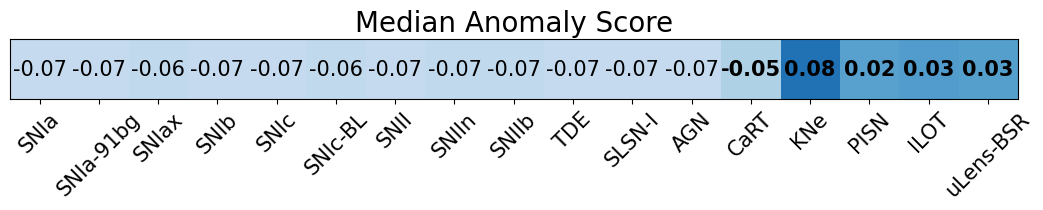

In [ ]:
# average_score(best.test_scores, y_val, best.anom_scores, y_data_anom, title=f"Median Anomaly Score\n(MCIF)", savepath=f'last/MedianScoreRedo')
median_score(best.test_scores, y_val, best.anom_scores, y_data_anom, title=f"Median Anomaly Score", savepath=f'last/MedianScore')


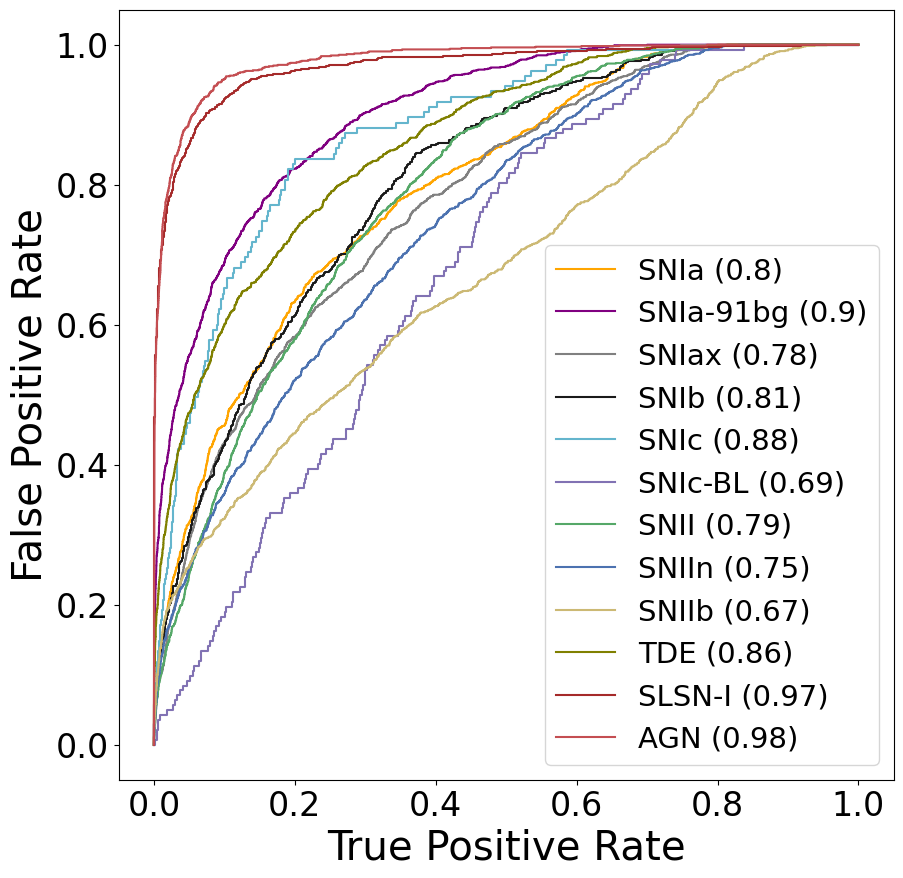

In [ ]:
# matplotlib.style.set('defualt')
plot_roc_curve(best.test_predictions, y_test, savepath='last/ROCCurvePreNoTitle')

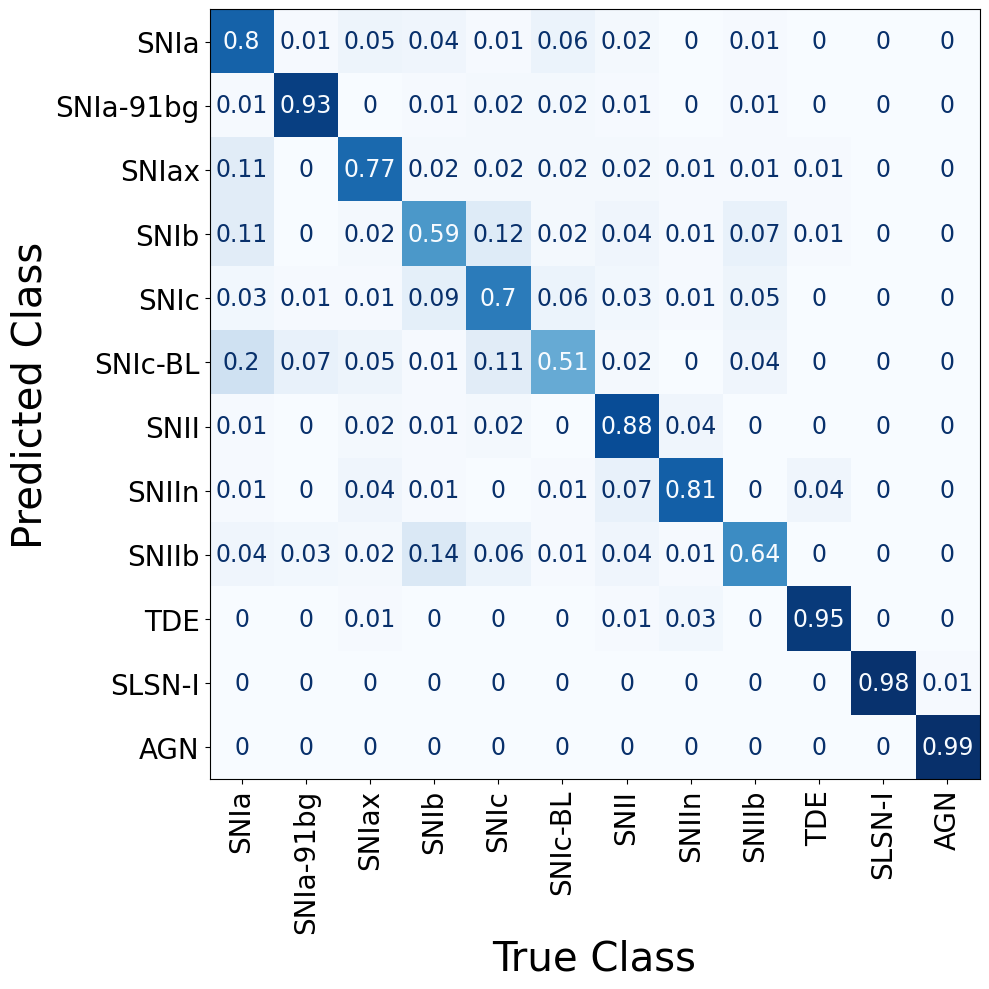

In [ ]:
font = {'size'   : 17}

matplotlib.rc('font', **font)

plot_confusion_matrix(best.test_predictions, y_test, savepath='last/ConfusionMatrix')

Here we generate the precision-recall curve, calculate precision and recall as defined in the paper

In [ ]:
from sklearn.metrics import auc

def get_pr(minority, majority): # takes minority and majority data and gets the precision-recall with minority being True Positive and majority being False Positive

    precision = []
    recall = []
    thresholds = []
    minority=np.array(minority)
    majority=np.array(majority)
    for threshold in np.arange(min(np.min(minority),np.min(majority)), max(np.max(minority),np.max(majority)) + 0.002, 0.001):
        ta = np.count_nonzero(minority > threshold)
        fa = np.count_nonzero(majority > threshold)
        tn = np.count_nonzero(majority < threshold)
        fn = np.count_nonzero(minority < threshold)
        if fn == 0 or fa == 0:
          continue
        if (ta + fa == 0):
            continue
        recall.append(ta / (ta + fn))
        precision.append(ta / (ta + fa))
        thresholds.append(threshold)
    return thresholds, precision, recall

def get_pr_auc(scores_maj, y_data_maj, scores_anom, y_data_anom): # Gets PR AUC, not actually used anywhere
    np.random.seed(60)
    
    aucs = {}
    
    for ind, i in enumerate(non_anom_classes):
        
        mult_iso_maj_class = [scores_maj[t] for t in range(len(scores_maj)) if non_anom_classes[np.argmax(y_data_maj[t])] == i]

        mult_iso_min_cur = np.random.choice(scores_anom, int(len(mult_iso_maj_class)), p=p_anom)

        thresholds, precision, recall = get_pr(mult_iso_maj_class, mult_iso_min_cur)

        aucs[file_to_class[i]] = auc(recall, precision)


    for ind, i in enumerate(anom_classes):
        mult_iso_min_class = [scores_anom[t] for t in range(len(y_data_anom)) if y_data_anom[t] == i] # all anomalies of current class (i)

        mult_iso_min_class = np.random.choice(mult_iso_min_class, int(min(len(scores_maj), len(mult_iso_min_class))))

        thresholds, precision, recall = get_pr(mult_iso_min_class, scores_maj)

        aucs[file_to_class[i]] = auc(recall, precision)

        
    return aucs

# IMPORTANT NOTE: RANDOM SUBSAMPLES

### Because a lot of the reported results rely on sampling a random subsample, I created the arrays p_norm and p_anom. These *rig* the probability of each transient being chosen randomly so that transients represented less frequently have a higher probability. This ensures an evenly sampled distribution. E.g. if we have 100 SNIa and 200 SNIIb in our majority sample, I still want the probability of choosing each to be the same.
### However you might want an uneven population distribution, in which case you can make p_anom and p_norm have all the same value or remove them when they are used.

In [ ]:
 

import matplotlib.gridspec as gridspec

class_weights_anom = {i: 0 for i in anom_classes}

for i in y_data_anom:
  class_weights_anom[i]+=1

print(class_weights_anom)
for i in list(class_weights_anom.keys()):
  class_weights_anom[i] = len(y_data_anom) / class_weights_anom[i]


p_anom = [class_weights_anom[i] for i in y_data_anom]

sum = np.sum(p_anom)

for i in range(len(p_anom)):
  p_anom[i] /= sum




# This function plots the precision recall curve
def plot_pr_anom(scores_maj, y_data_maj, scores_anom, y_data_anom, s=None):
    
    fig = plt.figure(figsize=(18, 12))
    gs = gridspec.GridSpec(2, 3, width_ratios=[1,2,0], height_ratios=[1,1], wspace=0.3)

    ax3 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[1, 0], sharex=ax3)
    ax = fig.add_subplot(gs[:, 1:3])

    ax.set_aspect('equal', 'box')
    
    plt.ylim((0, 1))
    plt.xlim((0, 1))
    l = 3 # Linewidth
    
    for ind, i in enumerate(anom_classes):
        mult_iso_min_class = [scores_anom[t] for t in range(len(scores_anom)) if y_data_anom[t] == i] # all anomalies of current class (i)

        mult_iso_min_class = np.random.choice(mult_iso_min_class, int(min(len(scores_maj), len(mult_iso_min_class)))) # Subset of these anomalies because we have less testing data

        thresholds, precision, recall = get_pr(mult_iso_min_class, scores_maj)
        ax.plot(recall, precision, label=f"{file_to_class[i]} ({round(auc(recall, precision), 2)})", c = color_from_class[i], linewidth=l)

        ax2.plot(thresholds, recall, label=f"{file_to_class[i]}", c = color_from_class[i], linewidth=l)

        ax3.plot(thresholds, precision, label=f"{file_to_class[i]}", c = color_from_class[i], linewidth=l)

    # Majority classes, defined below

    thresholds, precision, recall = plot_pr_maj(scores_maj, y_data_maj, scores_anom, y_data_anom)

    ax.plot(recall, precision, label=f"Common Classes ({round(auc(recall, precision), 2)})", c = 'grey', linewidth=l)

    ax2.plot(thresholds, recall, label=f"Common Classes", c = 'grey', linewidth=l)

    ax3.plot(thresholds, precision, label=f"Common Classes", c = 'grey', linewidth=l)


    ax.set_ylabel("Precision", fontsize=title_sz)
    ax.set_xlabel("Recall", fontsize=title_sz)
    ax.legend(fontsize=22)

    ax2.set_ylabel("Recall", fontsize=title_sz)
    ax2.set_xlabel("Threshold", fontsize=title_sz)
    # ax2.legend(fontsize=15)

    ax3.set_ylabel("Precision", fontsize=title_sz)
    ax3.set_xlabel("Threshold", fontsize=title_sz)
    # ax3.legend(fontsize=15)

    fig.suptitle("Anomaly Precision-Recall Curve", fontsize=33)
    ax.set_xticks(np.arange(0.2, 1.2, 0.2))


    saveplot(s)

def plot_pr_maj(scores_maj, y_data_maj, scores_anom, y_data_anom, s=None): # Returns precision/recall for majority classes. Not plotted

    
    mult_iso_maj_class = [scores_maj[t] for t in range(len(scores_maj))]
    mult_iso_maj_class = np.random.choice(mult_iso_maj_class, 10000, p=p_norm)

    mult_iso_min_cur = np.random.choice(scores_anom, int(len(mult_iso_maj_class)), p=p_anom)

    thresholds, precision, recall = get_pr(mult_iso_maj_class, mult_iso_min_cur)


    return thresholds, precision, recall



{'lc_classnum_CART_old.pickle': 10353, 'lc_classnum_Kilonova.pickle': 11166, 'lc_classnum_PISN_old.pickle': 10840, 'lc_classnum_ILOT_old.pickle': 11128, 'lc_classnum_uLens-BSR.pickle': 11244}


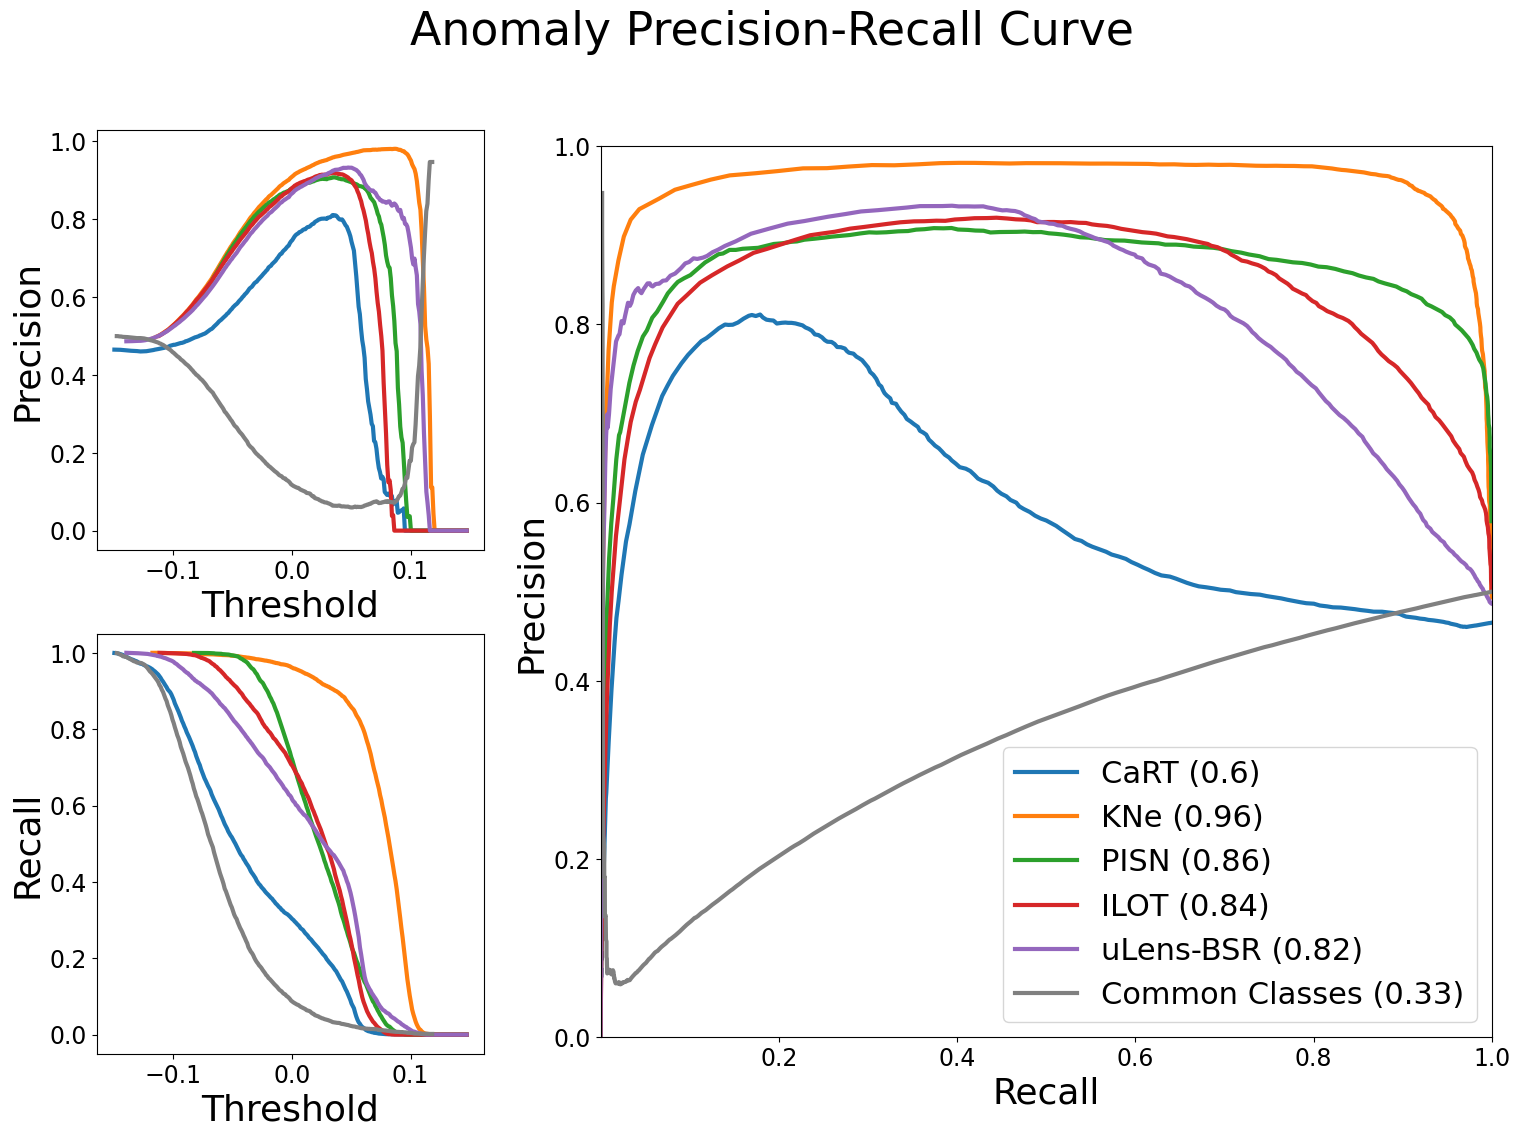

In [ ]:
plot_pr_anom(best.test_scores, y_test, best.anom_scores, y_data_anom, s="last/PRAnom")

In [ ]:
# Distribution of Anomaly Scores

import seaborn as sns

file_to_index = {x: list(file_to_class.values()).index(x) for x in file_to_class.values()}
def plot_dist(scores_maj, y_data_maj, scores_anom, y_data_anom, savepath=None): # Same input as average/median_score
    color = ['#ADD8E6'] * 12 + ['#FF6645'] * 5
    
    x=[]
    g=[]

    for i in range(len(scores_maj)):
        g.append(ordered_class_names[np.argmax(y_data_maj[i])])
        x.append(scores_maj[i])

    for i in range(len(scores_anom)):
        g.append(file_to_class[y_data_anom[i]])
        x.append(scores_anom[i])

    df = pd.DataFrame(dict(x=x, g=g))

    df.sort_values('g', inplace=True, key=lambda x: x.map(file_to_index))

    

    sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
    # Initialize the FacetGrid object
    g = sns.FacetGrid(df, row="g", hue="g", aspect=15, height=.5, palette=color)

    # Draw the densities in a few steps
    g.map(sns.kdeplot, "x",
          bw_adjust=.5, clip_on=False,
          fill=True, alpha=1, linewidth=1.5)
    g.map(sns.kdeplot, "x", clip_on=False, color="w", lw=2, bw_adjust=.5)

    # passing color=None to refline() uses the hue mapping, but we do color = 'blue'
    g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


    # Define and use a simple function to label the plot in axes coordinates
    def label(x, color, label):
        ax = plt.gca()
        ax.text(0, .2, label, fontweight="bold", color=color,
                ha="left", va="center", transform=ax.transAxes)


    g.map(label, "x")

    # Set the subplots to overlap
    g.figure.subplots_adjust(hspace=-.25)

    # Remove axes details that don't play well with overlap
    g.set_titles("")
    g.set(yticks=[], ylabel="")
    g.set(xlabel="Anomaly Score")

    g.despine(bottom=True, left=True)
    g.fig.suptitle(title, fontsize=23)

    if (savepath):
        g.figure.savefig(f"{savepath}.pdf", bbox_inches='tight')

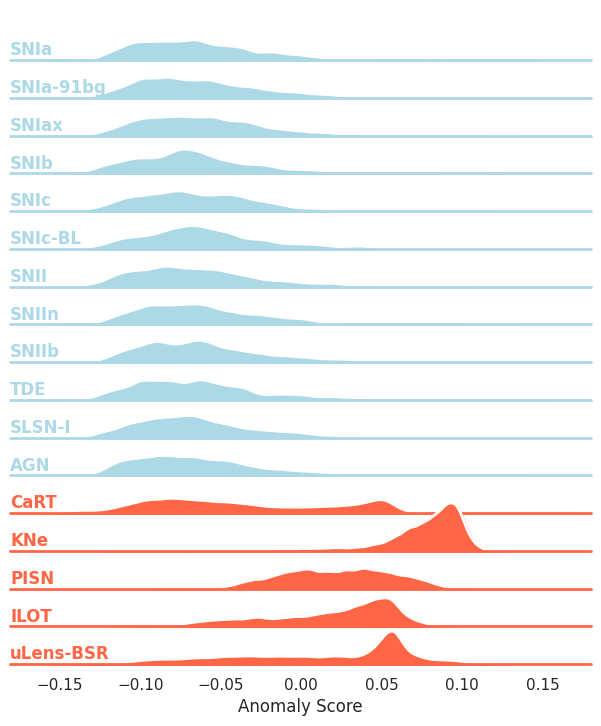

In [ ]:
plot_dist(best.test_scores, y_val, best.anom_scores, y_data_anom, title=f"", savepath=f'last/Distribution')

In [ ]:
# Randomly create subsamples and plot
all_counts = {}
from copy import deepcopy
def plot_recall(majority, minority, s=None, seed=100): # USE DEFAULT SEED! :)
    np.random.seed(seed)

    k = 50

    pref_counts = {}
    pref_recall = {}
    freqs = {}
    for key in ['All'] + anom_classes:
        pref_counts[key] = []
        pref_recall[key] = []
        freqs[key] = []

    for i in ordered_class_names:
        freqs[i] = []
    
    
    rigged_p_anom = p_anom.copy()

    # Uncomment to remove CaRTs

    # for i in range(len(p_anom)):
    #     if y_data_anom[i] == class_to_file['CaRT']:
    #         rigged_p_anom[i] = 0

    # sm = np.sum(rigged_p_anom)
    # for i in range(len(rigged_p_anom)):
    #     rigged_p_anom[i] /= sm


    
    for _ in range(k):

      freq = {i : 0 for i in pref_counts.keys()}
      for i in ordered_class_names:
          freq[i] = 0

      random_sample_maj = majority
   
    
      min_mask = np.random.choice(range(len(minority)), int(len(majority)/220), p = rigged_p_anom) # Change /220 for different ratio
      random_sample_min = np.array(minority)[min_mask]
      min_classes = np.array(y_data_anom)[min_mask]
        
      # print(len(random_sample_maj), len(random_sample_min))

      full_sample = [(i, ordered_class_names[np.argmax(y_test[ind])]) for ind, i in enumerate(random_sample_maj)] + [(i, min_classes[ind]) for ind, i in enumerate((random_sample_min))]
      full_sample = list(reversed(sorted(full_sample)))

      pref_sample = {i : [0] for i in anom_classes}
      pref_sample['All'] = [0]

     
      for i in full_sample:
        freq['All'] += 1
        pref_sample['All'].append(pref_sample['All'][-1] + (i[1] in anom_classes))
        
        for key in anom_classes:
           if (i[1] == key):
               freq[key] += 1
           pref_sample[key].append(pref_sample[key][-1] + (i[1] == key))

        for key in ordered_class_names:
            if (i[1] == key):
               freq[key] += 1

      prefr_sample = deepcopy(pref_sample)
      for i in pref_sample.keys():
          prefr_sample[i] = np.array(pref_sample[i]) / freq[i]
          # assert(np.max(prefr_sample[i]) <= 1)

        
      for key in pref_sample.keys():
          pref_counts[key].append(pref_sample[key])
          pref_recall[key].append(prefr_sample[key])
          freqs[key].append(freq[key])

      for key in ordered_class_names:
          freqs[key].append(freq[key])
          

    for i in freqs.keys():
        print(i, np.mean(freqs[i]), np.std(freqs[i]))

        all_counts[i]=freqs[i]
    # return
            
    final = []
            
    for key, value in pref_counts.items():
      med = []
      dev = []

      medr = []
      devr = []
        
        
      pref_counts = np.array(value).T
      rec_here = np.array(pref_recall[key]).T

      for i in range(len(pref_counts)):
        pref_counts[i] = np.array(pref_counts[i])
        rec_here[i] = np.array(rec_here[i])

        # assert(np.max(rec_here[i]) <= 1)
        # if (key == 'All'):
        #     print(i, pref_sample[key][i])
        med.append(np.mean(pref_counts[i]))
        dev.append(np.std(pref_counts[i]))

        medr.append(np.mean(rec_here[i]))
        devr.append(np.std(rec_here[i]))


      
      med=np.array(med)
      dev = np.array(dev)

      medr=np.array(medr)
      devr = np.array(devr)

      # print(np.max(medr + devr))
      
      final.append([med, dev, key, medr, devr])

    
    font = {'size'   : 17}

    matplotlib.rc('font', **font)
    
    fig, ax = plt.subplots()

    

    ax.set_xlim(0, 2000)
    ax.set_xlabel("Index (Top 2000 Scores)", fontsize=18)
    ax.set_ylabel("Recall", fontsize=18)

    ax.set_title("Anomalies Detected by Index", fontsize=21)

    ax2 = ax.twinx()

    ax2.set_ylabel('Detected Anomalies', fontsize=16)
    
    ind = 0

    # Comment if you don't want guessing line
    x = np.array(range(0,2000))
    y = 1/220 * x
    plt.plot(x, y, label='Guessing', linestyle='dashed', color='grey')

   
    
    for med, dev, label, medr, devr in final:
        if (label != 'All'): # running this loop through with 'All' plots result for all classes
            
            continue
 
        if label == 'All'):
            ax.plot(medr, label=file_to_class[label] if label != 'All' else 'This Work', color=color_from_class[file_to_class[label]])
            ax.fill_between(range(1, len(med) + 1), medr + devr, medr-devr, alpha = 0.2, color=color_from_class[file_to_class[label]])
        else:
            ax2.plot(range(1, len(med) + 1), med, label=file_to_class[label] if label != 'All' else 'This Work', color = u'#ff7f0e') # color=color_from_class[file_to_class[label]])
            ax2.fill_between(range(1, len(med) + 1), med + dev, med-dev, alpha = 0.2, color = u'#ff7f0e')# , color=color_from_class[file_to_class[label]])

    
    
    ax2.set_ylim(-0.1 * int(len(majority) / 220), 1.1 * int(len(majority) / 220))
    ax.set_ylim(-0.1, 1.1)

    
    ax.tick_params(axis='y')
    
    
    plt.legend(fontsize=14)

    plt.tight_layout()

    saveplot(s)

All 11952.0 0.0
lc_classnum_CART_old.pickle 11.24 3.0761014287568607
lc_classnum_Kilonova.pickle 11.3 3.3120990323358392
lc_classnum_PISN_old.pickle 11.22 2.8586010564610094
lc_classnum_ILOT_old.pickle 10.02 3.159050490258109
lc_classnum_uLens-BSR.pickle 10.22 2.7661525626761807
AGN 1042.0 0.0
SNII 1301.0 0.0
SNIIb 1208.0 0.0
SNIIn 1318.0 0.0
SNIa-91bg 1321.0 0.0
SNIa 1142.0 0.0
SNIax 1339.0 0.0
SNIb 563.0 0.0
SNIc-BL 142.0 0.0
SNIc 135.0 0.0
SLSN-I 1273.0 0.0
TDE 1114.0 0.0
4.08 1.9270703152713446
11.14 3.346699867033194
10.16 2.6333248945012464
8.02 2.935915530120034
7.22 2.6251857077166942


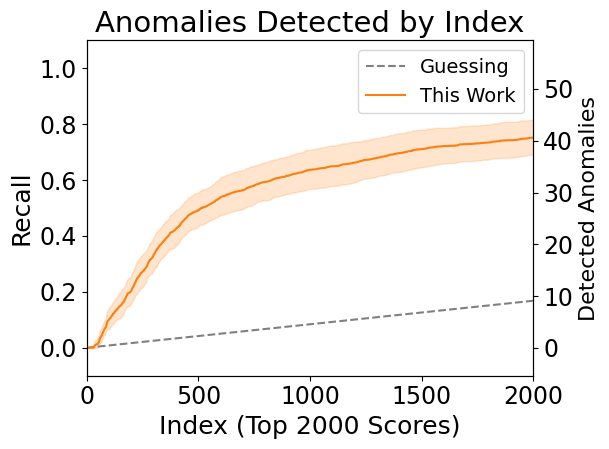

In [ ]:
plt.style.use('default')
plot_recall(best.test_scores, best.anom_scores, s='last/AnomByInd')


In [ ]:

for i_ in anom_classes:
    # i=file_to_class[i_]
    i=i_
    print(i, int(np.mean(all_counts[i])), "\pm", int(np.std(all_counts[i])))


lc_classnum_CART_old.pickle 11 \pm 3
lc_classnum_Kilonova.pickle 10 \pm 3
lc_classnum_PISN_old.pickle 11 \pm 3
lc_classnum_ILOT_old.pickle 10 \pm 3
lc_classnum_uLens-BSR.pickle 10 \pm 2


In [ ]:
latent_size=9
def plot_history(filepath, s= None):
    hist = load(filepath) 
    
    plt.plot(range(1, len(hist.history['val_accuracy']) + 1), hist.history['val_accuracy'], label='Validation Accuracy')
    plt.plot(range(1, len(hist.history['accuracy']) + 1), np.array(hist.history['accuracy']), label='Training Accuracy') #  * len(X_val) /  len(X_train)
    
    plt.xlabel("Epoch", fontsize=17)
    plt.ylabel("Accuracy", fontsize=17)
    
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    
    plt.legend(fontsize=14)
    
    # plt.title('Training/Validation Accuracy', fontsize=19)
    saveplot(s)

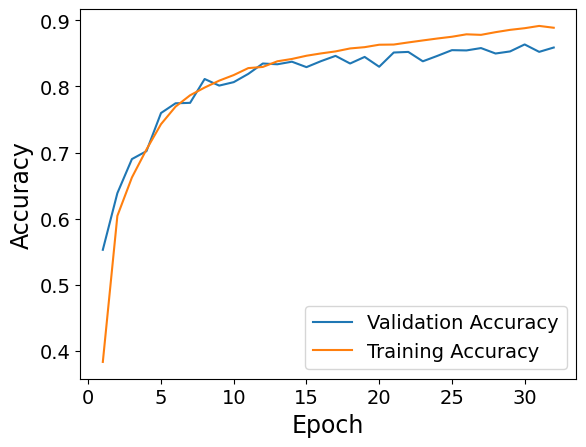

In [ ]:
matplotlib.style.use('default')

plot_history(f'Models/RedshiftLatent_{latent_size}_historyFINALFINAL', s = 'last/AccuracyHistory')

In [ ]:
# Get UMAP reducer and plot UMAP


def get_reducer(data): # Basic function
    reducer = umap.UMAP(random_state=5, min_dist=0.5, n_neighbors=500)

    reducer.fit(data)
    
    embedding=reducer.transform(data)
    
    return reducer, embedding
    
def plot_umap(embedding, labels, legend, uni=None, title='', savepath='', color=color): # This is very specific to my dataset, I'd reccomending writing your own code if you want to see the UMAP reduction
    plt.figure(figsize=(10, 10))
    if uni == None:
        uni = np.unique(labels)

    print(uni)
    for cc, i in enumerate(uni):
        
        e=[]
        for ind, point in enumerate(labels):
            # print(point)
            if point == i:
                e.append(embedding[ind])
        
        assert(not len(e) == 0)
        e = np.array(e)
        if (type(i) == int):
            plt.scatter(e[:, 0], e[:, 1], label=file_to_class[non_anom_classes[i]], c=color_from_class[file_to_class[non_anom_classes[i]]]) # if cc != 0 else 'grey'
        elif (i in anom_classes):
            plt.scatter(e[:, 0], e[:, 1], label=file_to_class[i], c=color_from_class[i]) # if cc != 0 else 'grey'
        else:
            plt.scatter(e[:, 0], e[:, 1], label=i, c="Grey") # if cc != 0 else 'grey'

        
        
    plt.title(title, fontsize=27)
    # plt.xlabel('Arbritary Units', fontsize=17)
    # plt.ylabel('Arbritary Units', fontsize=17)
    plt.xticks(range(-5, 25, 5))
    plt.yticks(range(-5, 25, 5))
    
    plt.xlabel('UMAP 1', fontsize=17)
    plt.ylabel('UMAP 2', fontsize=17)
    plt.legend(fontsize=17,loc="upper right")
    saveplot(savepath)
    
    # return reducer

In [ ]:
import umap
best.te_reducer, best.te_embedding = get_reducer(best.test_latent)

In [ ]:
best.tr_reducer, best.tr_embedding = get_reducer(best.train_latent)
best.a_reducer, best.a_embedding = get_reducer(best.anom_latent)
# best.te_reducer, best.te_embedding = get_reducer(best.test_latent)

In [ ]:
save("FINALFINAL", best)

In [ ]:
best = load("FINALFINAL")

In [ ]:

plot_umap(best.tr_embedding, [np.argmax(i) for i in y_train], [file_to_class[i] for i in non_anom_classes], uni = [ordered_class_names.index(file_to_class[i]) for i in non_anom_classes], title = "UMAP Reduction on Training Data", savepath="last/UMAPTrain")

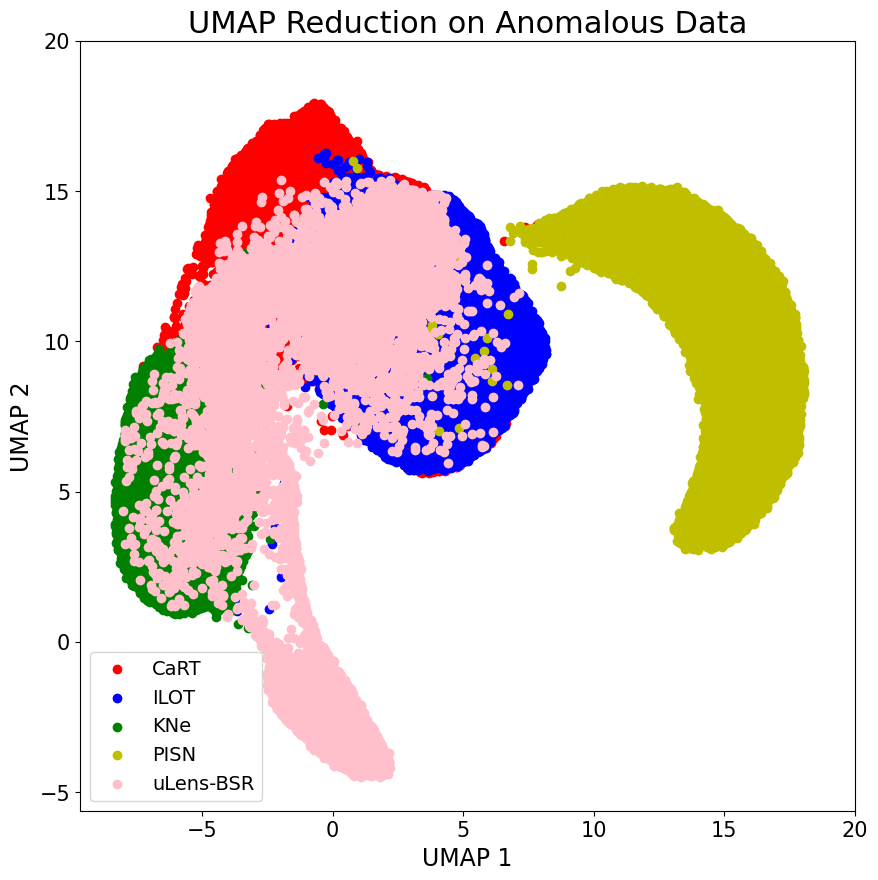

In [ ]:
plot_umap(best.a_embedding, y_data_anom, [file_to_class[i] for i in reversed(np.unique(y_data_anom))], title="UMAP Reduction on Anomalous Data", savepath="last/UMAPAnom")

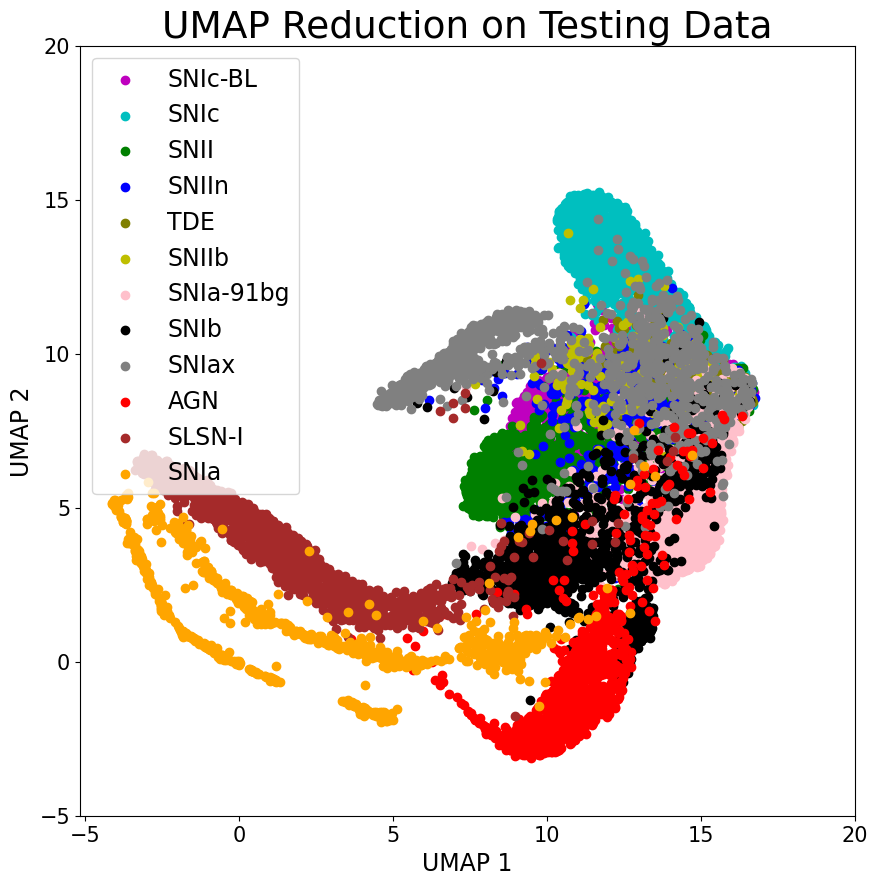

In [ ]:
plot_umap(best.te_embedding, [np.argmax(i) for i in y_test], ordered_class_names, uni = [ordered_class_names.index(file_to_class[i]) for i in non_anom_classes], title="UMAP Reduction on Testing Data", savepath="last/UMAPTest")

['Common Transients' 'lc_classnum_CART_old.pickle'
 'lc_classnum_ILOT_old.pickle' 'lc_classnum_Kilonova.pickle'
 'lc_classnum_PISN_old.pickle' 'lc_classnum_uLens-BSR.pickle']


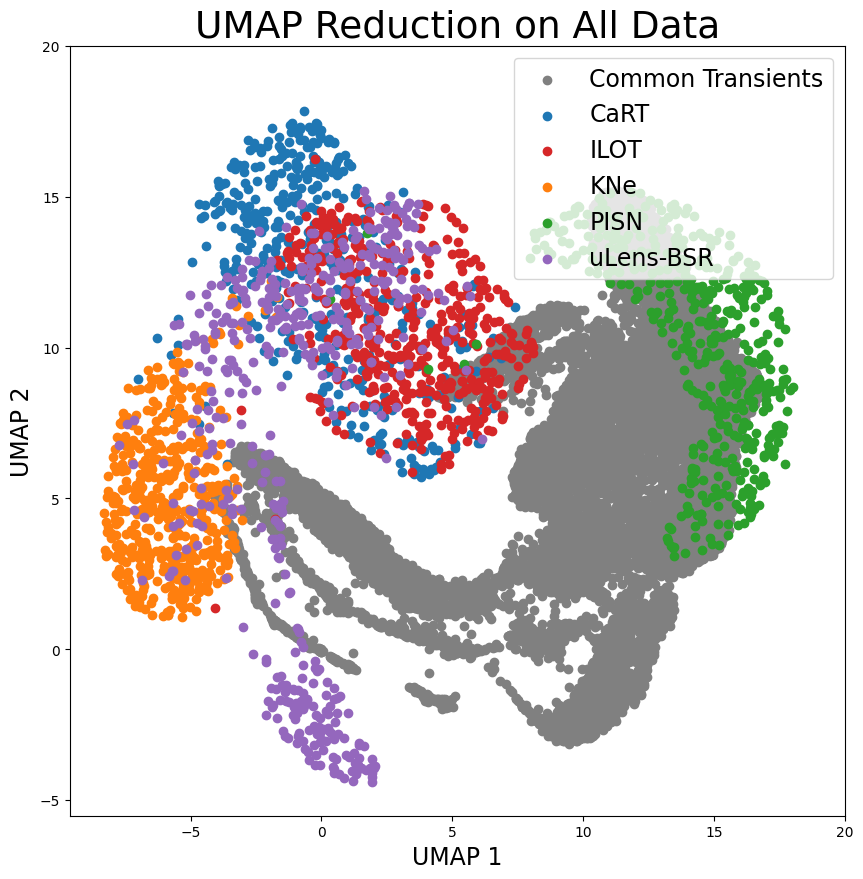

In [ ]:
idx = np.random.choice(np.arange(len(best.a_embedding)), round(len(best.te_embedding)/5), replace=False)
vals = best.a_embedding[idx]
labels = np.array(y_data_anom)[idx]

plot_umap(np.append(best.te_embedding, vals, axis=0), ['Common Transients' for i in y_test] + list(labels), ['Common Transients'] + [file_to_class[i] for i in np.unique(labels)], title="UMAP Reduction on All Data", savepath="last/UMAPAll")

In [ ]:
save("FinalTrainedModel", best)

'best)' was not found in history, as a file, url, nor in the user namespace.


In [ ]:
def cut_curve(lc, cutoff, ind=False): # assumes scaled cutoff and uses binary search
  # print(lc.shape)
  lo = 0
  hi = len(lc)-1

  while (lo < hi):
    m = (lo + hi)//2
    # print(lc[m][1], cutoff)
    if (lc[m][1] > cutoff or not np.any(lc[m][1])):
      hi = m
    else:
      lo = m+1

  # print(lo)
  
  if (not ind):
      for i in range(hi, len(lc)):
        if (not np.any(lc[i])):
          break
    
        lc[i] = np.zeros(4)

  if (not ind):
    return lc
  else:
    if (not np.any(lc[hi])):
        hi-=1
    return hi

In [ ]:
# Real Time Results

# Redefine p_anom and p_norm

p_norm = [class_weights[np.argmax(i)] for i in y_test]

sum = np.sum(p_norm)

for i in range(len(p_norm)):
  p_norm[i] /= sum

class_weights_anom = {i: 0 for i in anom_classes}

for i in y_data_anom:
  class_weights_anom[i]+=1

print(class_weights_anom)
for i in list(class_weights_anom.keys()):
  class_weights_anom[i] = len(y_data_anom) / class_weights_anom[i]

p_anom = [class_weights_anom[i] for i in y_data_anom]


sum = np.sum(p_anom)

for i in range(len(p_anom)):
  p_anom[i] /= sum




def get_anomaly_real_time(curves, host_galaxy, inds, model): # get real time scores for the indices inds. Inputs are curves and host_galaxy
    # print('d')
    splits = []
    lcs = []
    host_gals = []
    for ind in inds:
        cur = np.zeros((ntimesteps, 4))
        anomaly_scores = []
        host_gal = np.array(host_galaxy[ind])
        curve = curves[ind]
        
        for ind, i in enumerate(curve):
            if (np.count_nonzero(i) == 0):
                break
            cur[ind]=i

            lcs.append(cur.copy())
            host_gals.append(host_gal)
    
        splits.append(len(lcs))

    lcs = np.array(lcs)
    host_gals = np.array(host_gals)

    scores = model.score(model.latent_model.predict([np.array(lcs), np.array(host_gals)]))
    
    ans = []
    prv=0
    for diff in splits:
        ans.append(scores[prv:diff])
        prv=diff
    return ans

def plot_real_median(X_test, x_data_anom, model, savepath="", classes=file_to_class.values()):
    
    # assert(len(norm_scores) == len(anom_scores) and len(norm_scores) == 200)
    
    norm_median = []
    norm_deviation = []
    
    class_median = {file_to_class[i]: [] for i in non_anom_classes}
    class_deviation = {file_to_class[i]: [] for i in non_anom_classes}


    cutoffs = list(range(-30, 71, 1))

    for t in cutoffs:
      cur_class = {file_to_class[i] : [] for i in non_anom_classes} # list of scores for each class at this cutoff
        
      cur_values = []
      for ind in range(len(normal_inds)):

        cutoff = cut_curve(np.copy(X_test[normal_inds[ind]]), (t+30)/100, ind=True)

        # if (X_test[normal_inds[ind]][cutoff][1] <= (t+30-5)/100):
        #   continue
        cur_values.append(norm_scores[ind][min(cutoff, len(norm_scores[ind])-1)])
        
        cur_class[ordered_class_names[np.argmax(y_test[normal_inds[ind]])]].append(norm_scores[ind][min(cutoff, len(norm_scores[ind])-1)])
        
      for c in non_anom_classes:
        # if (t == 0):
            # print(np.mean(cur_class[c]))
        # print(file_to_class[c], t, len(cur_class[c]))
        cur_class[file_to_class[c]] = np.array(cur_class[file_to_class[c]])
        class_median[file_to_class[c]].append(np.median(cur_class[file_to_class[c]]))
        class_deviation[file_to_class[c]].append(np.median(np.absolute(cur_class[file_to_class[c]] - np.median(cur_class[file_to_class[c]]))))

      cur_values=np.array(cur_values)

      norm_median.append(np.median(cur_values))
      norm_deviation.append(np.median(np.absolute(cur_values - np.median(cur_values))))

    norm_median = np.array(norm_median)
    norm_deviation = np.array(norm_deviation)

    fig, ax = plt.subplots(figsize=(8, 8))

    for class_ in non_anom_classes:
        class_ = file_to_class[class_]
        class_median[class_] = np.array(class_median[class_])
        class_deviation[class_] = np.array(class_deviation[class_])

        if (class_ in classes):
            ax.plot(cutoffs, class_median[class_], '-', label=class_, color=color_from_class[class_])
            ax.fill_between(cutoffs, class_median[class_] - class_deviation[class_], class_median[class_] + class_deviation[class_], alpha=0.2, color=color_from_class[class_])



    plt.legend()
    # return
    

    # Remove if you don't want majority aggregate
    maj_col = u'grey'
    ax.plot(cutoffs, norm_median, '-', label="Common Classes", color=maj_col)
    ax.fill_between(cutoffs, norm_median - norm_deviation, norm_median + norm_deviation, alpha=0.2, color=maj_col)
    # ax.plot(cutoffs, norm_median, 'o', color=maj_col)


    anom_median = []
    anom_deviation = []

    class_median = {i: [] for i in anom_classes}
    class_deviation = {i: [] for i in anom_classes}

    class_flux = {i : [] for i in anom_classes}
    class_flux_dev = {i : [] for i in anom_classes}

    for t in cutoffs:

      cur_values = []
      cur_class = {i : [] for i in anom_classes}
      cur_flux = {i : [] for i in anom_classes}
      for ind in range(len(anom_inds)):
        cutoff = cut_curve(np.copy(x_data_anom[anom_inds[ind]]), (t+30)/100, ind=True)

        
        cur_values.append(anom_scores[ind][min(cutoff, len(anom_scores[ind])-1)])
        
        cur_class[y_data_anom[anom_inds[ind]]].append(anom_scores[ind][min(cutoff, len(anom_scores[ind])-1)])
          
        cur_flux[y_data_anom[anom_inds[ind]]].append(x_data_anom[ind][min(cutoff, len(anom_scores[ind])-1)])
        
      for c in anom_classes:

        cur_class[c] = np.array(cur_class[c])
        class_median[c].append(np.median(cur_class[c]))
        class_deviation[c].append(np.median(np.absolute(cur_class[c] - np.median(cur_class[c]))))

        cur_flux[c] = np.array(cur_flux[c])
        class_flux[c].append(np.median(cur_flux[c]))
        class_flux_dev[c].append(np.median(np.absolute(cur_flux[c] - np.median(cur_flux[c]))))

      cur_values=np.array(cur_values)

      anom_median.append(np.median(cur_values))
      anom_deviation.append(np.median(np.absolute(cur_values - np.median(cur_values))))

    anom_median = np.array(anom_median)
    anom_deviation = np.array(anom_deviation)

    # Remove this if you don't want anomalous aggregate
    ax.plot(cutoffs, anom_median, '-', label="Anomalous", color=u'#ff7f0e')
    ax.fill_between(cutoffs, anom_median - anom_deviation, anom_median + anom_deviation, alpha=0.2, color=u'#ff7f0e')

    
    for ind, c in enumerate(anom_classes):
        if (file_to_class[c] not in classes and c not in classes):
            continue

    
        ax.plot(cutoffs, class_median[c], '-', label=file_to_class[c],  color=color_from_class[c])
        ax.fill_between(cutoffs, np.array(class_median[c]) - np.array(class_deviation[c]), np.array(class_median[c]) + np.array(class_deviation[c]), alpha=0.2,  color=color_from_class[c])

    ax.set_xlabel("Time", fontsize=25)
    ax.set_ylabel("Median Anomaly Score", fontsize=25)
    ax.legend(fontsize=16)

    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.ylim(-0.1, 0.1)
    

    # ax.set_title("Median Anomaly Score Over Time", fontsize=28)
    # plt.show()
    saveplot(savepath)

{'lc_classnum_CART_old.pickle': 10353, 'lc_classnum_Kilonova.pickle': 11166, 'lc_classnum_PISN_old.pickle': 10840, 'lc_classnum_ILOT_old.pickle': 11128, 'lc_classnum_uLens-BSR.pickle': 11244}


In [ ]:
# Get the random sample of inds/scores

normal_inds = np.random.choice(list(range(len(X_test))), 2000, p=p_norm, replace=False)
anom_inds = np.random.choice(list(range(len(x_data_anom))), 2000, p = p_anom, replace=False)

anom_scores = get_anomaly_real_time(x_data_anom, host_gal_anom, anom_inds, best)

norm_scores = get_anomaly_real_time(X_test, host_gal_test, normal_inds, best)

3139/3139 [==============================] - 777s 247ms/step


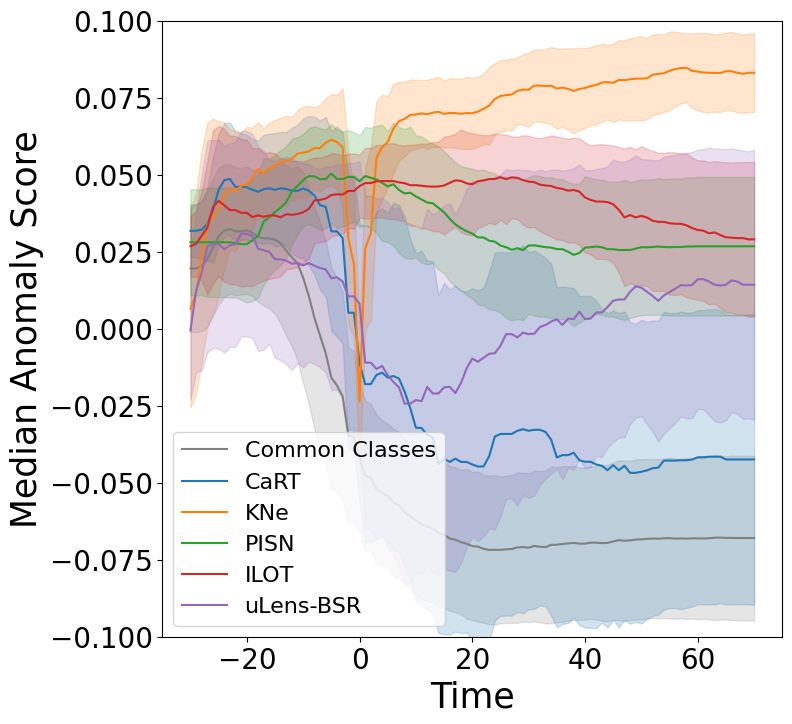

In [ ]:
plt.style.use('default')

# plot_real_median(X_test, x_data_anom, best, "last/MajScale", ['SNIa', 'SNIIn', 'SLSN-I', 'KNe'])
plot_real_median(X_test, x_data_anom, best, "last/AnomScale", anom_classes) # ['SNIa', 'SNIIn', 'SLSN-I', 'KNe']

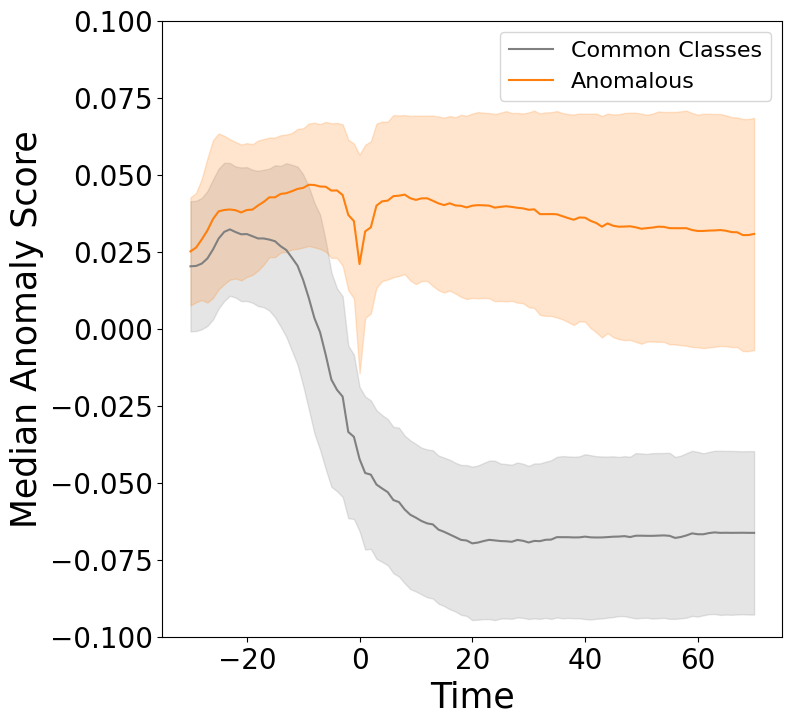

In [ ]:
plot_real_median(X_test, x_data_anom, best, "last/AllScale", [])

### The following 2 codeblocks are really just for debugging. Use them for sample usage of the plot_real_time function (which is defined 3 blocks below)

In [ ]:
# Debug

ind = 100
import random
x_data_div = x_data_anom.copy()

    
cnt = 0
while True:

    if (file_to_class[y_data_anom[ind]] == 'uLens-BSR'):
        plot_real_time(get_anomaly_real_time(x_data_div, host_gal_anom, [ind], best)[0], x_data_div[ind], file_to_class[y_data_anom[ind]])

        if (cnt == 10):
            break
        
        
    ind+=1


In [ ]:
# DEBUG
import random
ind = 0

cnt = 0
while True:

    if (ordered_class_names[np.argmax(y_test[ind])] == 'SNIa'):
        cnt += 1
        if (cnt == 10):
            break

        plot_real_time(get_anomaly_real_time(X_test, np.zeros((len(X_test), 2)), [ind], best)[0], X_test[ind], ordered_class_names[np.argmax(y_test[ind])])

    ind+=1

In [ ]:
def plot_real_time(classification_scores, curve, class_):
    cur = np.array([(j[1] * 100) - 30 for j in curve])
    assert(not np.any(curve[len(classification_scores)]))
    cur = cur[:len(classification_scores)]
 
    r_band = []
    rer = []
    r_cur = []
    g_band = []
    ger = []
    g_cur = []

    for i in curve[:len(classification_scores)]:
        if (i[0] < 0.5):
            r_band.append(i[2])
            rer.append(i[3])
            r_cur.append((i[1] * 100) - 30)

        else:
            g_band.append(i[2])
            ger.append(i[3])
            g_cur.append((i[1] * 100) - 30)





    fig, axs = plt.subplots(2, figsize=(10, 20))

    plt.subplots_adjust(wspace=0, hspace=0)

    axs[0].set_title(f"Real Time Anomaly Score for a {class_}", fontsize=30)


    axs[0].set_ylabel('Scaled Flux', fontsize=27)
    axs[0].errorbar(r_cur, r_band, yerr=rer, fmt='.', label= 'r band')
    axs[0].errorbar(g_cur, g_band, yerr = ger, fmt = '.', label= 'g band')


    axs[1].set_ylabel('Anomaly Score', fontsize=27)
    axs[1].set_xlabel('Time Since Trigger', fontsize=27)
    axs[1].plot(cur, classification_scores)

    axs[1].set_ylim(-0.3, 0.3)
    axs[1].set_yticks(ticks=np.arange(-0.3, 0.3, 0.1))

    axs[0].tick_params(axis='both', labelsize=27)
    axs[1].tick_params(axis='both', labelsize=27)
    

    
    

    # axs[1].axhline(0.05, linestyle='--', color='r')

    axs[1].legend()
    plt.axvline(0, linestyle='--', color='r')

    saveplot(f"NewEx/{class_}Example{random.randint(1, 1000)}")
    plt.show()

    

### The next part is only there to produce a pretty plot for the paper :). I would ignore it

In [ ]:
inds = {
    "SNIa": 0,
    "SNIa-91bg": 11598,
    "SNIax":24800,
    "SNIb":43171,
    "SNIc":48450,
    "SNIc-BL":50052,
    "SNII":51471,
    "SNIIn":78884,
    "SNIIb":97091,
    "TDE":109392,
    "SLSN-I":120754,
    "AGN":138142,
    "CaRT":144631,
    "KNe":154531,
    "PISN":166504,
    "ILOT":177026,
    "uLens-BSR":187880
}

In [ ]:
# Finding good examples
from sklearn.preprocessing import MinMaxScaler

# fig, axs = plt.subplots(1, 2, figsize=(20, 30), sharey=True)
# fig.subplots_adjust(hspace=0)


done = {i : False for i in file_names}

def plot_curves(name, num = 100):

    band_medians = {'r' : 0.4827, 'g' : 0.6223}
    cnt = 0

    for ind in range(len(x_data)):

        if (target[ind] == name and cut_curve(x_data[ind], 1, ind=True) > 55 and host_galaxy_info[ind][0] < 0.5):
            
            maxi = np.max(x_data[ind][:, 2])
            mini = np.min(x_data[ind][:, 2])
            x_data[ind][:, 2] = (x_data[ind][:, 2] - mini) / (maxi - mini)
            x_data[ind][:, 3] /= (maxi - mini)

            done[target[ind]] = True
            cnt += 1


            red = x_data[ind][x_data[ind][:, 0] == band_medians['r']]
            green = x_data[ind][x_data[ind][:, 0] == band_medians['g']]
            plt.errorbar(red[:, 1], ((red[:, 2] + 30) * 100), fmt='^', alpha=0.3, color = colors[file_names.index(target[ind]) % len(colors)])
            plt.errorbar(green[:, 1], ((green[:, 2] + 30) * 100), fmt='o', alpha=1, color = colors[file_names.index(target[ind])  % len(colors)])

            # axs[int(cnt > 8)].errorbar(new_vals[:, 1] * 100 - 30, new_vals[:, 2] + prv_mx, fmt='o', color = colors[file_names.index(target[ind]) % len(colors)])
            # plt.text(0, prv_mx + x_data[0][2] + 0.5, file_to_class[target[ind]], fontsize=20, color = colors[file_names.index(target[ind]) % len(colors)])

            # prv_mx += np.max(new_vals[:, 2]) + 0.5

            
            plt.ylabel('Scaled Flux + Offset', fontsize=15)
            plt.xlabel('Time Since Trigger', fontsize=15)
            plt.title(str(ind))
            
            plt.show()

        if (cnt == 100):
            break
    
    # plt.title('Sample Light Curves')
    # plt.ylim(-1, 29)
    # saveplot("Figures/samplecurves")
    
plot_curves(class_to_file['uLens-BSR'])

In [ ]:
interesting_inds = list(inds.values()) # [6, 13024, 26037, 39092, 44415, 45914, 47312, 60322, 73318, 85658, 97110, 114369, 120846, 130758, 144661, 153253, 164107]

In [ ]:
class_to_file = {v: k for k, v in file_to_class.items()}

In [ ]:
for key, value in file_to_class.items():
    color_from_class[value] = color_from_class[key]

KeyError: 'lc_classnum_Ia.pickle'

In [ ]:
for i in range(len(x_data)):
    if (file_to_class[target[i]] == 'SNIa'):
        plot_curve(x_data[i])
        break

NameError: name 'plot_curve' is not defined

In [ ]:

from sklearn.preprocessing import MinMaxScaler


plt.figure(figsize=(10, 40))
# fig, axs = plt.subplots(1, 2, figsize=(20, 30), sharey=True)
# fig.subplots_adjust(hspace=0)


done = {i : False for i in file_names}



band_medians = {'r' : 0.4827, 'g' : 0.6223}
prv_mx = 0
cnt = 0

for ind in reversed(interesting_inds): # [6, 13024, 26037, 39092, 44415, 45914, 47312, 60322, 73318, 97110, 85658, 114369, 130758, 144661, 153253, 164107, 120846]:
    # print(ind)
    maxi = np.max(x_data[ind][:, 2])
    mini = np.min(x_data[ind][:, 2])
    x_data[ind][:, 2] = (x_data[ind][:, 2] - mini) / (maxi - mini)
    x_data[ind][:, 3] /= (maxi - mini)

    done[target[ind]] = True
    cnt += 1
    if (cnt >= 10):
        break

    red = x_data[ind][x_data[ind][:, 0] == band_medians['r']]
    green = x_data[ind][x_data[ind][:, 0] == band_medians['g']]
    plt.errorbar((red[:, 1]) * 100 - 30, red[:, 2] + prv_mx, fmt='^', alpha=0.3, color = color_from_class[file_to_class[target[ind]]])
    plt.errorbar((green[:, 1]) * 100 - 30, green[:, 2] + prv_mx, fmt='o', alpha=1, color = color_from_class[file_to_class[target[ind]]])

    # axs[int(cnt > 8)].errorbar(new_vals[:, 1] * 100 - 30, new_vals[:, 2] + prv_mx, fmt='o', color = colors[file_names.index(target[ind]) % len(colors)])
    plt.text(5, prv_mx + 0.5, file_to_class[target[ind]] + "        ", fontsize=25, color = color_from_class[file_to_class[target[ind]]], ha='right', va='bottom')

    prv_mx += 1.2

        
plt.ylabel('Scaled Flux + Offset', fontsize=25)
plt.xlabel('Time Since Trigger', fontsize=25)

# plt.title('Sample Light Curves')
# plt.ylim(-1, 29)
saveplot("last/samplecurves2")

 # Testing with a Single Isolation Forest

In [ ]:
# recalculate class weights

class_weights = {i : 0 for i in range(y_train.shape[1])}

for value in y_train:
  class_weights[np.argmax(value)]+=1

for value in y_val:
  class_weights[np.argmax(value)]+=1

for id in class_weights.keys():
  class_weights[id] = (len(y_train) + len(y_val)) / class_weights[id]

sample_weights = [class_weights[np.argmax(i)] for i in y_train] + [class_weights[np.argmax(i)] for i in y_val]

from sklearn.ensemble import IsolationForest

best.iforest = IsolationForest(random_state=0, max_samples = 'auto', n_estimators=200).fit(np.append(best.train_latent, best.val_latent, axis=0), sample_weight=sample_weights)



In [ ]:
best.single_scores = -best.iforest.decision_function(best.test_latent)
best.single_scores_anom = -best.iforest.decision_function(best.anom_latent)

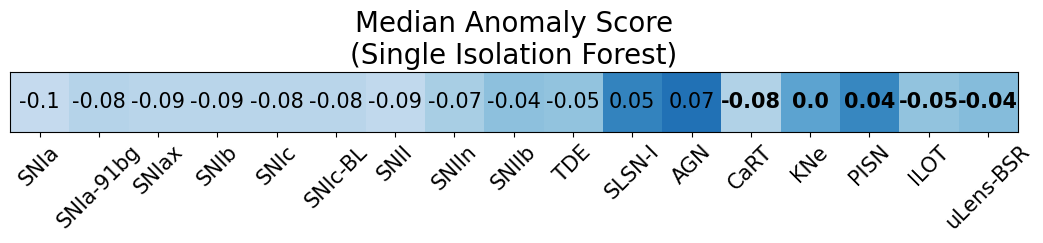

In [ ]:
# average_score(best.single_scores, y_test, best.single_scores_anom, y_data_anom, title="Average Anomaly Score\n(Single Isolation Forest)", savepath="FiguresNew/AverageScoreSingle")
median_score(best.single_scores, y_test, best.single_scores_anom, y_data_anom, title="Median Anomaly Score\n(Single Isolation Forest)", savepath="FiguresNew/MedianScoreSingle")


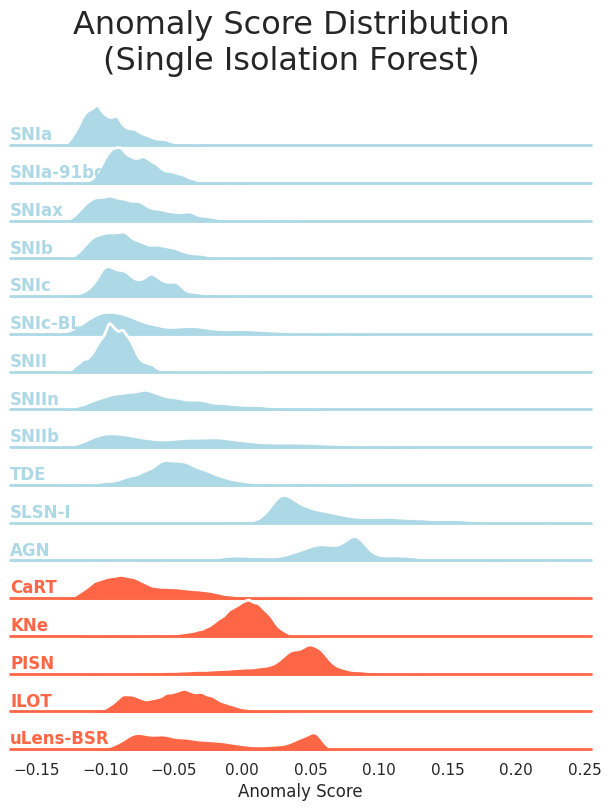

In [ ]:
plot_dist(best.single_scores, y_test, best.single_scores_anom, y_data_anom, title="Anomaly Score Distribution\n(Single Isolation Forest)", savepath="FiguresNew/ScoreDistSingle")

In [ ]:
def get_classification_real(curves, host_galaxy, inds, model): # Real time classification scores. Input is similar to real time anomaly scores
    # print('d')
    splits = []
    lcs = []
    host_gals = []
    for ind in inds:
        cur = np.zeros((ntimesteps, 4))
        anomaly_scores = []
        host_gal = np.array(host_galaxy[ind])
        curve = curves[ind]
        
        for ind, i in enumerate(curve):
            if (np.count_nonzero(i) == 0):
                break
            cur[ind]=i

            lcs.append(cur.copy())
            host_gals.append(host_gal)
    
        splits.append(len(lcs))

    lcs = np.array(lcs)
    host_gals = np.array(host_gals)

    scores = model.model.predict([np.array(lcs), np.array(host_gals)])
    
    ans = []
    prv=0
    for diff in splits:
        ans.append(scores[prv:diff])
        prv=diff
    return ans

def get_roc_auc(predictions, ind, labels, savepath=None):
    
    predictions=np.array(predictions)
    fpr, tpr, _ = roc_curve(y_true = labels, y_score = predictions[:, ind], pos_label = ind)

    return auc(fpr, tpr)

def plot_real_auc(X_test, x_data_anom, model, savepath="", classes=file_to_class.values()): # Plot real-time AUROCs, should be easy
    
    plt.figure(figsize=(8, 8))
    class_auc = {file_to_class[i]: [] for i in non_anom_classes}


    cutoffs = list(range(-30, 71, 1))
    
    labels = [np.argmax(y_test[i]) for i in normal_inds]
    
    for t in cutoffs:
      here = []
      for ind in range(len(normal_inds)):
    
        cutoff = cut_curve(np.copy(X_test[normal_inds[ind]]), (t+30)/100, ind=True)

        here.append(norm_scores[ind][min(cutoff, len(norm_scores[ind])-1)])
    
      for ind, cl in enumerate(ordered_class_names):
        class_auc[cl].append(get_roc_auc(here, ind, labels))


    for c in range(len(ordered_class_names)):
        if (ordered_class_names[c] in classes):
            plt.plot(cutoffs, class_auc[ordered_class_names[c]], label=ordered_class_names[c], color = color_from_class[ordered_class_names[c]])

    # return
    plt.legend(fontsize=18)

    plt.xticks(fontsize=22)
    plt.yticks(fontsize=22)
    
    plt.ylabel("AUROC", fontsize=27)
    plt.xlabel("Time", fontsize=27)
    plt.title("Classification AUROC Over Time", fontsize=29)
    # plt.ylim(-0.1, 0.1)
    

    # ax.set_title("Median Anomaly Score Over Time", fontsize=28)
    # plt.show()
    saveplot(savepath)

In [ ]:
normal_inds = np.random.choice(list(range(len(X_test))), 2000, p=p_norm, replace=False)
norm_scores = get_classification_real(X_test, host_gal_test, normal_inds, best)

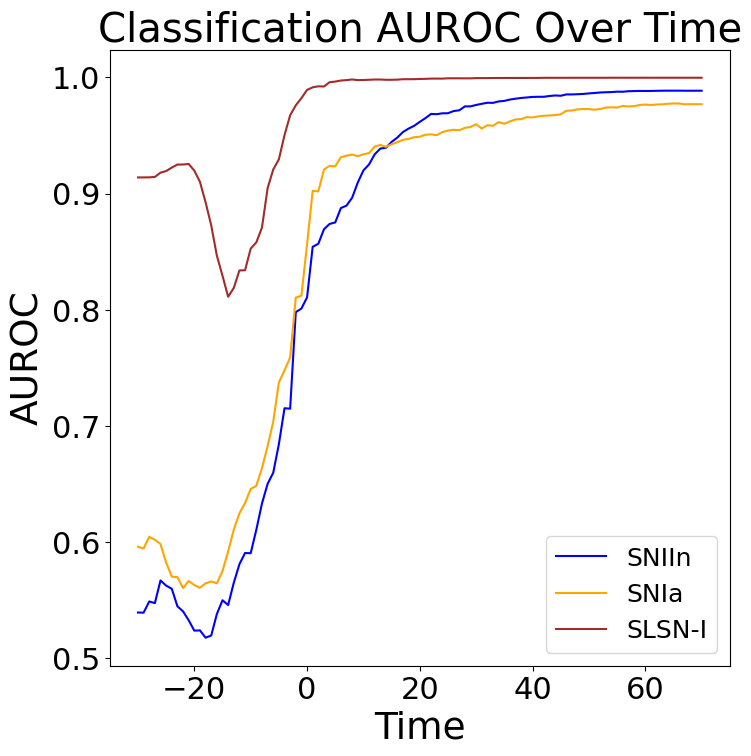

In [ ]:
plot_real_auc(X_test, x_data_anom, best, classes = ["SLSN-I", "SNIIn", "SNIa"], savepath = "last/realclassmaj")

In [ ]:


import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, TimeDistributed, Dense, Masking, concatenate, GRU
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

class Detect:
    ntimesteps=656

    @classmethod
    def pad(cls, x_data):
        for ind in range(len(x_data)):
            np.pad(x_data[ind], ((0, cls.ntimesteps - len(x_data[ind])), (0, 0)))
        return x_data

    @classmethod
    def init(cls):
        with open("pretrained", 'rb') as f:
            cls.mod = pickle.load(f)

        
        # cls.mod = Custom(ntimesteps, 4, 2, 9, y_train.shape[-1])
        # cls.mod.custom_model(best.model, 'lc', 'host', 'latent')
        # cls.mod.create_encoder()
        # cls.mod.mcif = mcif()
        # cls.mod.mcif.iforests = best.iso_forests

    @classmethod
    def classify(cls, x_data, host_gal):
        return cls.mod.classify(x_data, host_gal)

    @classmethod
    def anomaly_score(cls, x_data, host_gal):
        return cls.mod.score(x_data, host_gal)

    @classmethod
    def plot_real_time(cls, x_data, host_gal):
        cls.mod.plot_real_time(x_data, host_gal, [0.4827, 0.6223], x_data[:, 1] * 100 - 30, x_data[:, 2] * 500, x_data[:, 3] * 500, colors=['red', 'g'], names=['r', 'g'])
    
        
    

class Custom:
    def __init__(self, timesteps, features, contextual, latent_size, n_classes):
        self.n_classes=n_classes
        self.features=features
        self.contextual=contextual
        self.latent_size = latent_size
        self.timesteps=timesteps

    def pad(self, x_data):
        for ind in range(len(x_data)):
            np.pad(x_data[ind], ((0, self.timesteps - len(x_data[ind])), (0, 0)))
        return x_data

    def create_model(self):
        input_1 = Input((self.timesteps, self.features), name='lc')  # X.shape = (Nobjects, Ntimesteps, 4) CHANGE
        self.lc_name = 'lc'
        masking_input1 = Masking(mask_value=0.)(input_1)
    
        lstm1 = GRU(100, return_sequences=True, activation='tanh')(masking_input1)
        lstm2 = GRU(100, return_sequences=False, activation='tanh')(lstm1)
    
        dense1 = Dense(100, activation='tanh')(lstm2)

        if (self.contextual > 0):
            input_2 = Input(shape = (self.contextual, ), name='host') # CHANGE
            self.context_name = 'host'
            dense2 = Dense(10)(input_2)
            merge1 = concatenate([dense1, dense2])

        else:
            merge1 = dense1
    
        dense3 = Dense(100, activation='relu')(merge1)
    
        dense4 = Dense(self.latent_size, activation='relu', name='latent')(dense3)
    
        output = Dense(self.n_classes, activation='softmax')(dense4)

        if (self.contextual):
            self.model = keras.Model(inputs=[input_1, input_2], outputs=output)
        else:
            self.model = keras.Model(inputs=[input_1], outputs=output)
    
    
        self.model.compile(loss = "categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
        
        self.latent_name='latent'
        
    def custom_model(self, model, lc_name, context_name, latent_name):
        self.model=model
        self.lc_name = lc_name
        self.context_name = context_name
        self.latent_name=latent_name
        
    def train(self, X_train, y_train, x_val, y_val, savepath, host_gal_train = None, host_gal_val = None):
        
        early_stopping = EarlyStopping(
                                      patience=5,
                                      min_delta=0.001,                               
                                      monitor="val_loss",
                                      restore_best_weights=True
                                      )
        
        
        
        if (self.contextual > 0):
            self.history = self.model.fit(x = [X_train, host_gal_train], validation_data=([X_val, host_gal_val], y_val), y = y_train, epochs=40, batch_size = 128, class_weight = class_weights, callbacks=[early_stopping])
        else:
            self.history = self.model.fit(x = [X_train], validation_data=([X_val], y_val), y = y_train, epochs=40, batch_size = 128, class_weight = class_weights, callbacks=[early_stopping])
            
        
    
    def create_encoder(self):
        if (self.contextual):
            self.latent_model = Model(inputs=[self.model.get_layer(self.lc_name).input, self.model.get_layer(self.context_name).input], outputs=self.model.get_layer(self.latent_name).output)
        else:
            self.latent_model = Model(inputs=[self.model.get_layer(self.lc_name).input], outputs=self.model.get_layer(self.latent_name).output)
            

    def predict(self, x_data, host_gal=None):
        if (self.contextual > 0):
            return self.model.predict(x = [x_data, host_gal])
        else:
            return self.model.predict(x = [x_data])
        
        
    def encode(self, x_data, host_gal=None):
        if (self.contextual > 0):
            return self.latent_model.predict(x = [x_data, host_gal])
        else:
            return self.latent_model.predict(x = [x_data])
    
    def init_mcif(self, x_data, y_data, host_gal, n_estimators=100):
        self.mcif = mcif(n_estimators)
        self.mcif.train(self.encode(x_data, host_gal), y_data)
        
        

    def score(self, x_data, host_gal=None):
        return self.mcif.score(self.encode(x_data, host_gal))

    def get_anomaly_real_time(self, curves, host_galaxy=None):
        
        splits = []
        lcs = []
        host_gals = []
        for ind in range(len(curves)):
            cur = np.zeros((self.timesteps, 4))
            anomaly_scores = []
            if (self.contextual):
                host_gal = np.array(host_galaxy[ind])
            
            curve = curves[ind]
            
            for ind, i in enumerate(curve):
                if (np.count_nonzero(i) == 0):
                    break
                cur[ind]=i
    
                lcs.append(cur.copy())
                if (self.contextual):
                    host_gals.append(host_gal)
        
            splits.append(len(lcs))
    
        lcs = np.array(lcs)
        host_gals = np.array(host_gals)
    
        scores = self.score(np.array(lcs), np.array(host_gals))
        
        ans = []
        prv=0
        for diff in splits:
            ans.append(scores[prv:diff])
            prv=diff
        
        return ans


    def plot_real_time(self, x_data, host_gal, bands, time, flux, error, names = [], colors = []):
        cur = np.array([j[1] for j in x_data])
        classification_scores = self.get_anomaly_real_time([x_data], [host_gal])[0]
        
        cur = cur[:len(classification_scores)]
        assert(len(cur) == len(classification_scores))

        time = {i : [] for i in bands}
        flux = {i : [] for i in bands}
        error = {i : [] for i in bands}

        
    
        for i in x_data[:len(classification_scores)]:
            if (not np.any(i)):
                break
            flux[i[0]].append(i[2])
            error[i[0]].append(i[3])
            time[i[0]].append(i[1])
    
        fig, axs = plt.subplots(2, figsize=(10, 20))
    
        plt.subplots_adjust(wspace=0, hspace=0)
    
        axs[0].set_title(f"Real Time Anomaly Score", fontsize=30)
    
    
        axs[0].set_ylabel('Flux', fontsize=27)
        for ind, i in enumerate(bands):
            axs[0].errorbar(time[i], flux[i], yerr=error[i], fmt='.', label = names[ind] if len(names) else None, color = colors[ind] if len(colors) else None)
    
    
        axs[1].set_ylabel('Anomaly Score', fontsize=27)
        axs[1].set_xlabel('Time Since Trigger', fontsize=27)
        axs[1].plot(cur, classification_scores)
    
        axs[1].set_ylim(-0.3, 0.3)
        axs[1].set_yticks(ticks=np.arange(-0.3, 0.3, 0.1))
    
        axs[0].tick_params(axis='both', labelsize=27)
        axs[1].tick_params(axis='both', labelsize=27)
        
        axs[0].legend()

        plt.show()
        
        

class mcif:
    def __init__(self, n_estimators = 100):
        self.n_estimators=n_estimators

    def train(self, x_data, labels):
        self.classes = np.unique(labels, axis=0)
        self.iforests = [IsolationForest(n_estimators=self.n_estimators) for i in self.classes]
        
        for ind, cls in enumerate(self.classes):
            here = []
            for i in range(len(x_data)):
                if (list(cls) == list(labels[i])):
                    here.append(x_data[i])

            self.iforests[ind].fit(here)
            

    def score_discrete(self, data):
        scores = [-det.decision_function(data) for det in self.iforests]

        scores = np.array(scores)
        scores = scores.T

        return scores

    def score(self, data):
        return [np.min(i) for i in self.score_discrete(data)]

In [ ]:
from astromcad.astromcad import Custom, mcif, Detect

In [ ]:
# !pip3 install astromcad

test = Custom(656, 4, 0, 9, 12)
test.create_model()

In [ ]:
test.mcif = mcif()

In [ ]:
test.mcif.`(best.train_latent, y_train)

In [ ]:
test.create_encoder()

In [ ]:

save("pretrained", test)

2/2 [==============================] - 3s 199ms/step


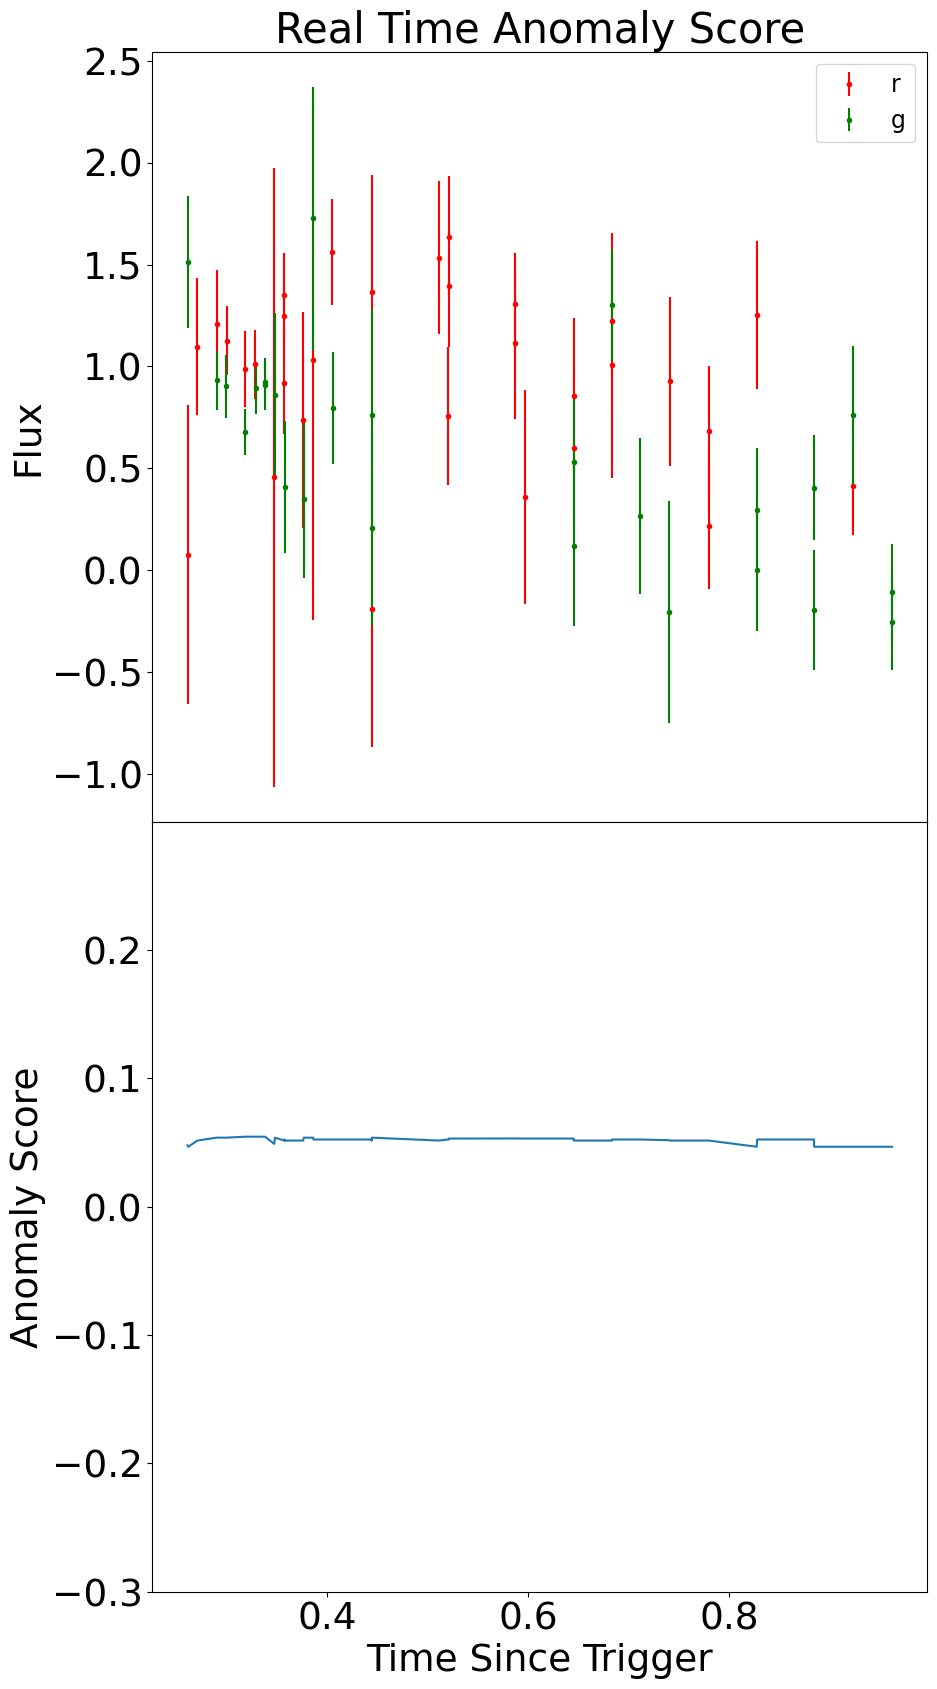

In [ ]:
test.plot_real_time(X_train[0], host_gal[0], [0.4827, 0.6223], X_train[0][:, 1], X_train[0][:, 2], X_train[0][:, 3], ['r', 'g'], ['red', 'green'])


In [ ]:
res = test.score(np.array([X_train[0]]), np.array([host_gal[0]]))

1/1 [==============================] - 0s 119ms/step


In [ ]:
from astromcad.astromcad import Detect
Detect.init()

2/2 [==============================] - 0s 206ms/step


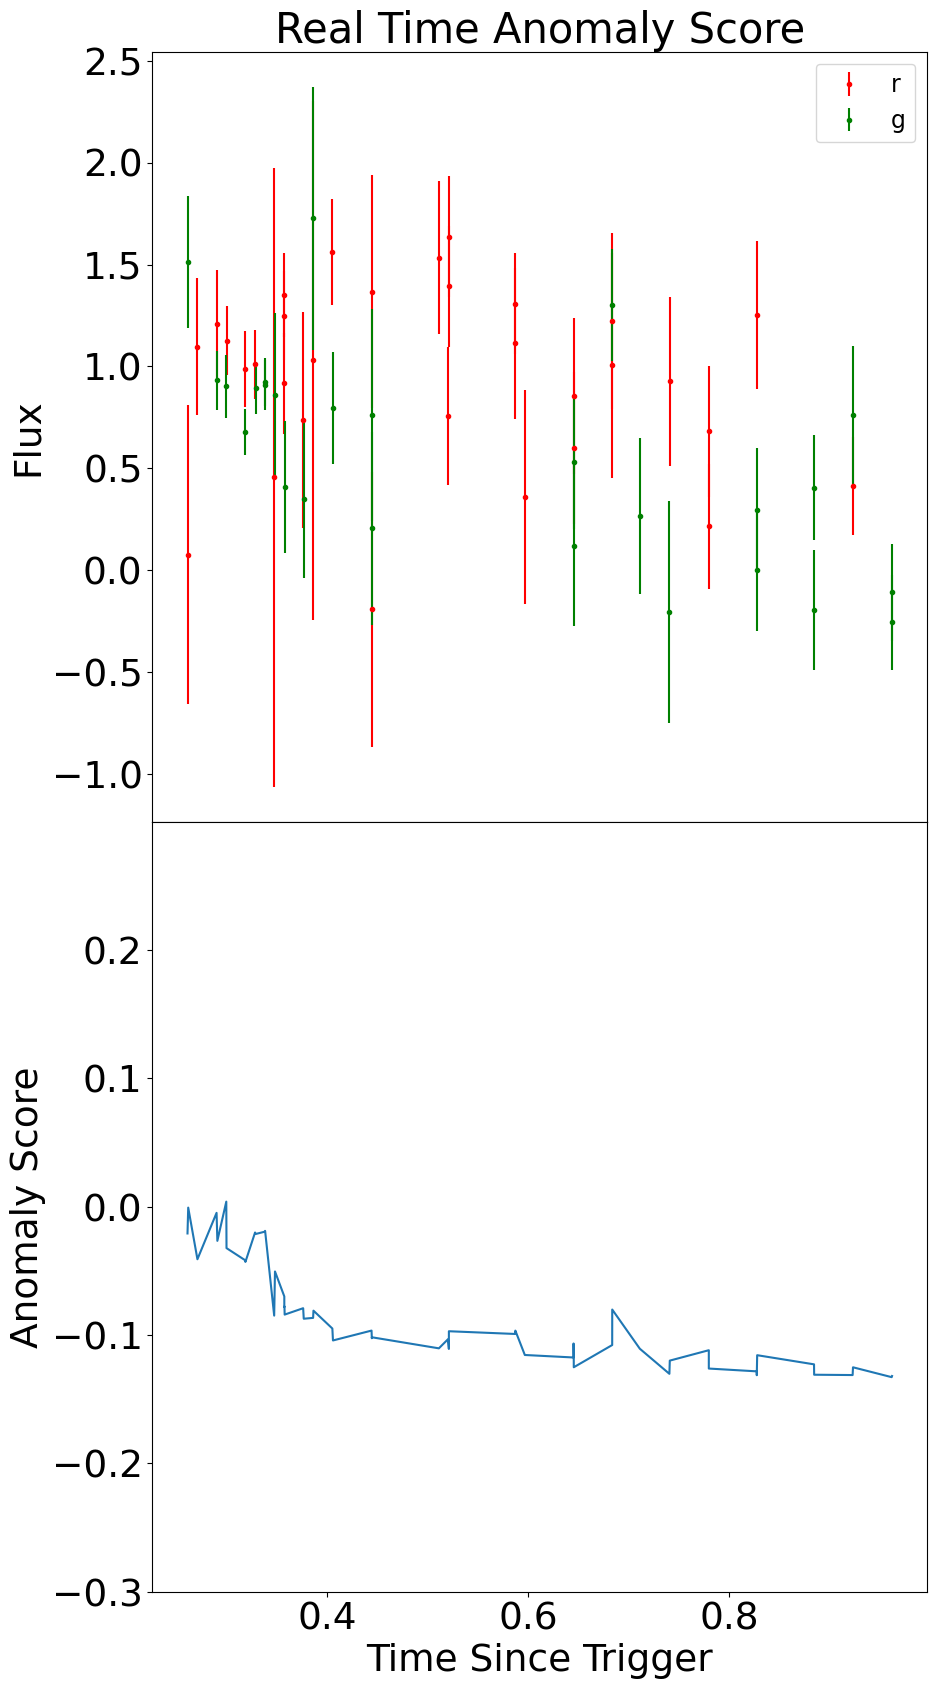

In [ ]:
Detect.plot_real_time(X_train[0], host_gal[0])

In [ ]:
res = test.score_discreet(best.train_latent)